In [1]:
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import os
import requests
import zipfile
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import pyodbc
import pandas as pd

In [2]:

url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"

data_dir = "countries_data"
shp_path = os.path.join(data_dir, "ne_110m_admin_0_countries.shp")
zip_path = os.path.join(data_dir, "ne_countries.zip")

os.makedirs(data_dir, exist_ok=True)

if not os.path.exists(zip_path):

    r = requests.get(url)   
    with open(zip_path, "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(data_dir)

data_dir = r"C:\Users\hp\Desktop\TPs\DataMining\DATA\Soil"
bil_path = os.path.join(data_dir, "HWSD2.bil")
mdb_path = os.path.join(data_dir, "HWSD2.mdb")


In [3]:

raster = rasterio.open(bil_path)


raster_data = raster.read(1, masked=True)
global_min = float(raster_data.min())
global_max = float(raster_data.max())
print(f"Global raster value range: {global_min} → {global_max}")


scale = 10  

data = raster.read(
    1,
    out_shape=(
        raster.height // scale,
        raster.width // scale
    ),
    resampling=Resampling.bilinear
)

 
data = data.astype(float)
data[data == raster.nodata] = float('nan')
 

Global raster value range: 2.0 → 49830.0


In [4]:

def clip_algeria_tunisia(shp_path, bil_path):

    # --- 2. Load shapefile and select Algeria + Tunisia ---
    countries = gpd.read_file(shp_path)
    north_africa = countries[countries["ADMIN"].isin(["Algeria", "Tunisia"])]

    if north_africa.empty:
        raise ValueError("Algeria or Tunisia not found in shapefile.")
    print("Shapefiles for Algeria and Tunisia loaded.")

    # --- 3. Read the raster and clip both countries ---
    raster = rasterio.open(bil_path)
    geoms = [mapping(geom) for geom in north_africa.geometry]

    out_image, out_transform = mask(raster, geoms, crop=True)
    out_meta = raster.meta.copy()
    out_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    raster_data = out_image[0].astype(float)
    raster_data = np.where(raster_data == raster.nodata, np.nan, raster_data)
    print("Raster clipped to Algeria + Tunisia region.")

    return raster_data, out_meta, out_image, north_africa


In [5]:

raster_data, out_meta, out_image, north_africa = clip_algeria_tunisia(shp_path, bil_path)

Shapefiles for Algeria and Tunisia loaded.
Raster clipped to Algeria + Tunisia region.


In [6]:
conn_str = (
    r"DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};"
    rf"DBQ={mdb_path};"
)
conn = pyodbc.connect(conn_str)

df_smu = pd.read_sql("SELECT * FROM HWSD2_SMU;", conn)
df_layer = pd.read_sql("SELECT * FROM HWSD2_LAYERS;", conn)
conn.close()


 
unique_ids = np.unique(raster_data[~np.isnan(raster_data)])
df_smu = df_smu[df_smu['HWSD2_SMU_ID'].isin(unique_ids)]
print(f"Matched {len(df_smu)} SMUs for Algeria + Tunisia.")

C:\Users\hp\AppData\Local\Temp\ipykernel_3820\2745405689.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_smu = pd.read_sql("SELECT * FROM HWSD2_SMU;", conn)
C:\Users\hp\AppData\Local\Temp\ipykernel_3820\2745405689.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_layer = pd.read_sql("SELECT * FROM HWSD2_LAYERS;", conn)


Matched 383 SMUs for Algeria + Tunisia.


In [7]:

df_layer_d1 = df_layer[df_layer["LAYER"].str.upper() == "D1"].copy()

 
selected_features = [
    "HWSD2_SMU_ID", "LAYER",  # keep IDs for linking
    "COARSE", "SAND", "SILT", "CLAY",
    "TEXTURE_USDA", "TEXTURE_SOTER",
    "BULK", "REF_BULK", "ORG_CARBON", "PH_WATER",
    "TOTAL_N", "CN_RATIO", "CEC_SOIL", "CEC_CLAY", "CEC_EFF",
    "TEB", "BSAT", "ALUM_SAT", "ESP", "TCARBON_EQ",
    "GYPSUM", "ELEC_COND"
]

df_layer_d1 = df_layer_d1[selected_features]

In [8]:
df_joined = pd.merge(
    df_smu[["HWSD2_SMU_ID"]],
    df_layer_d1,
    on="HWSD2_SMU_ID",
    how="inner"
)

print(f"{len(df_joined)} D1-layer soil units matched with raster.")

 
numeric_props = (
    df_joined.select_dtypes(include=[np.number])
    .columns.drop(["HWSD2_SMU_ID"], errors="ignore")
    .tolist()
)

858 D1-layer soil units matched with raster.


📊 Génération du rapport pour COARSE...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


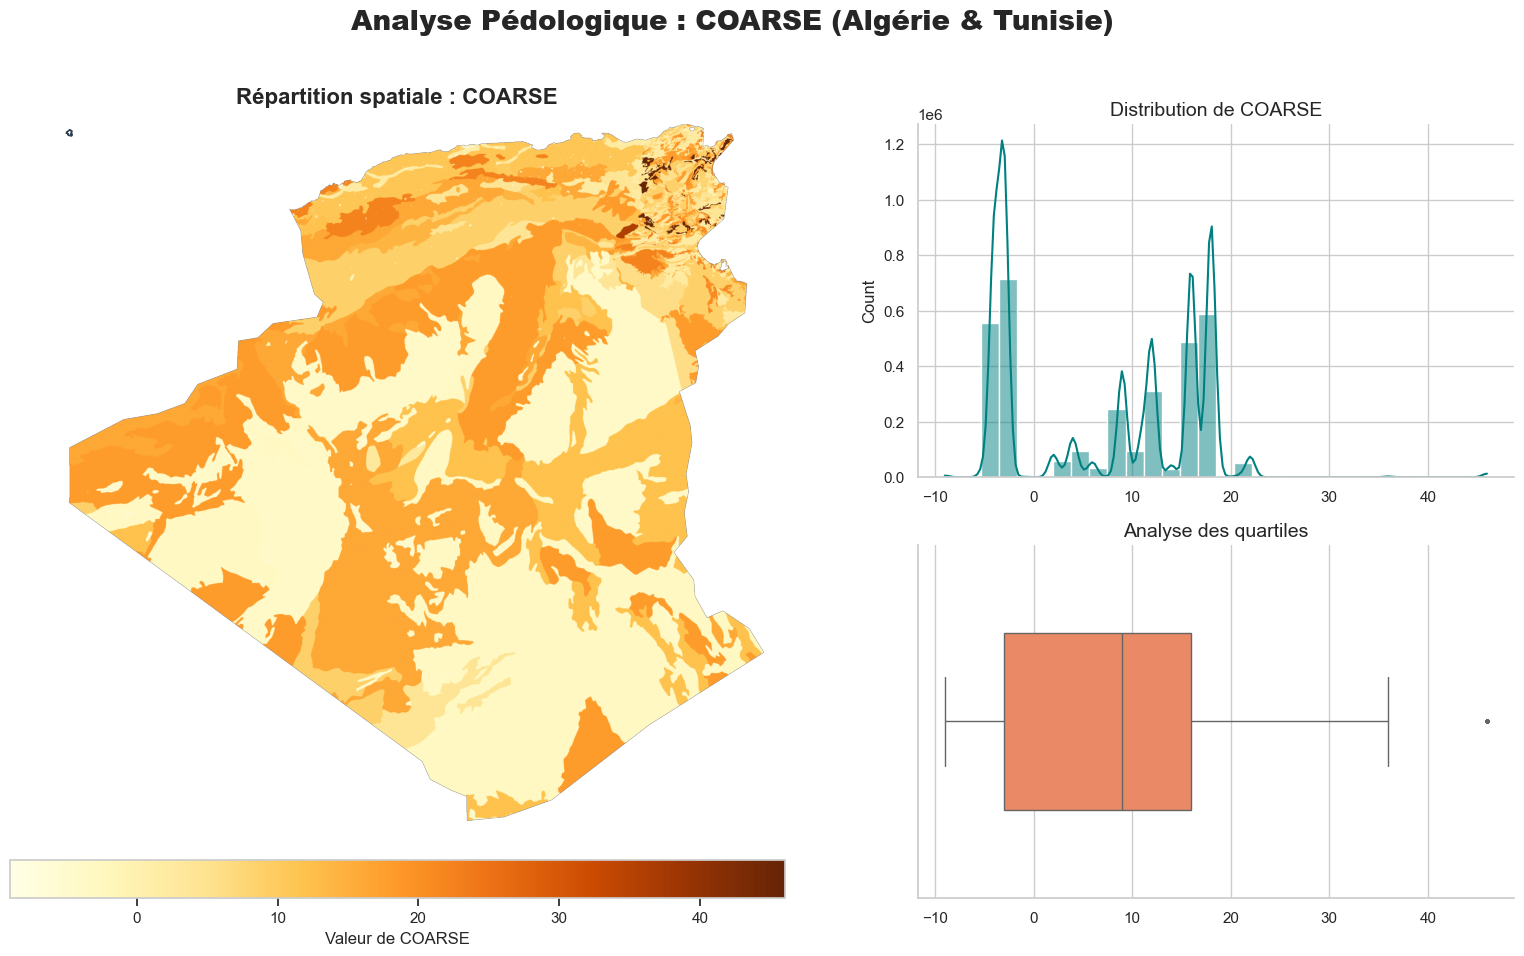

📊 Génération du rapport pour SAND...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


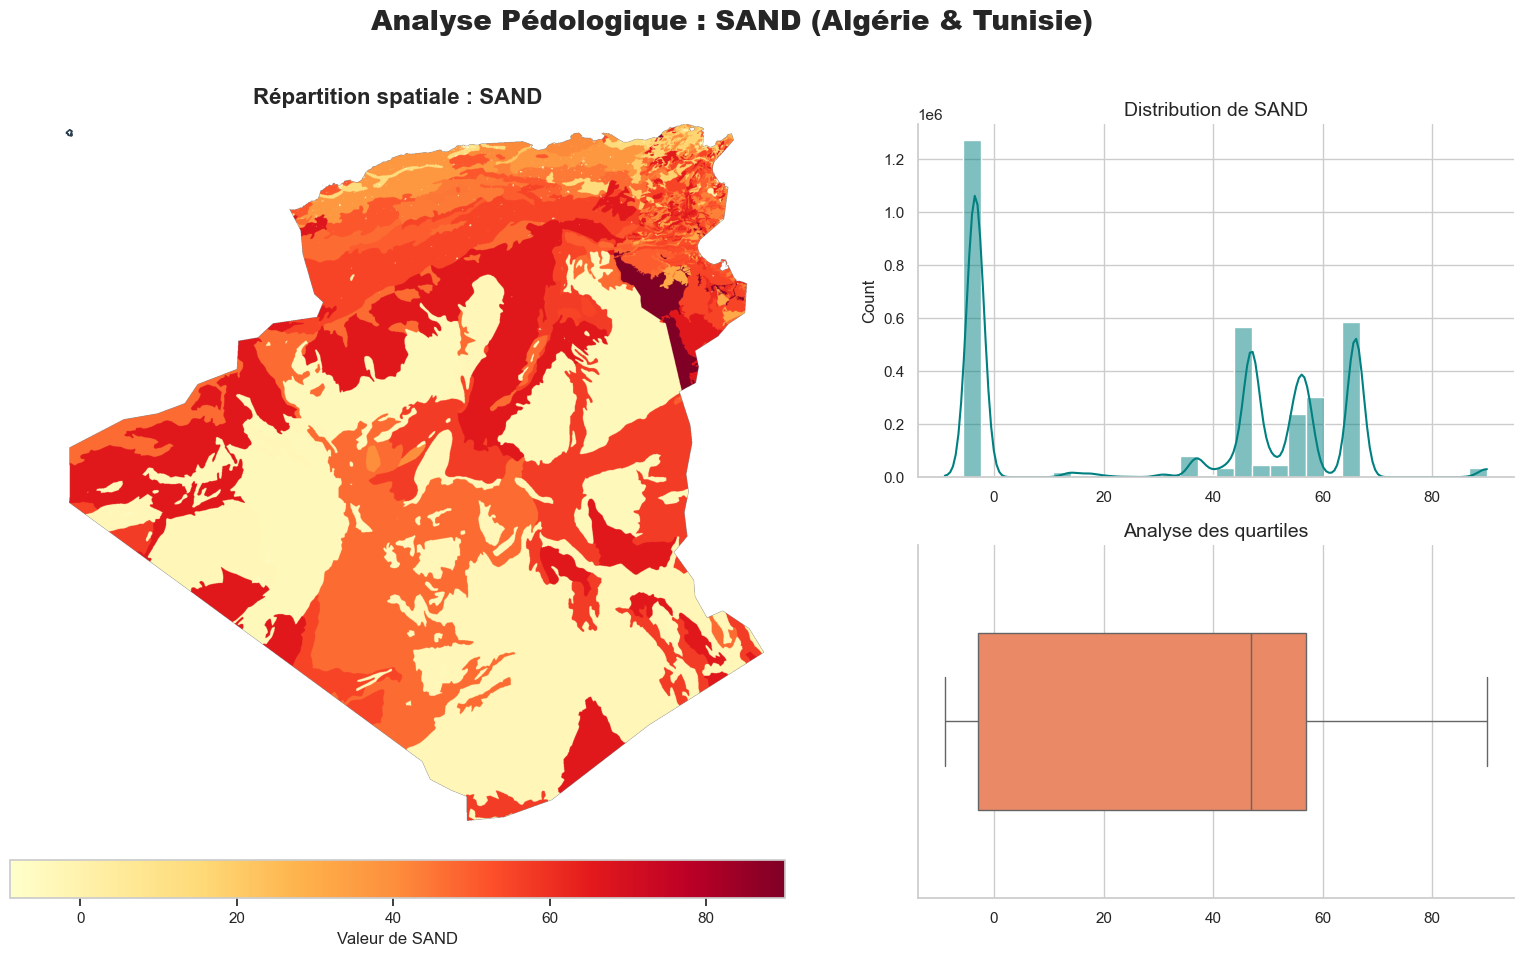

📊 Génération du rapport pour SILT...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


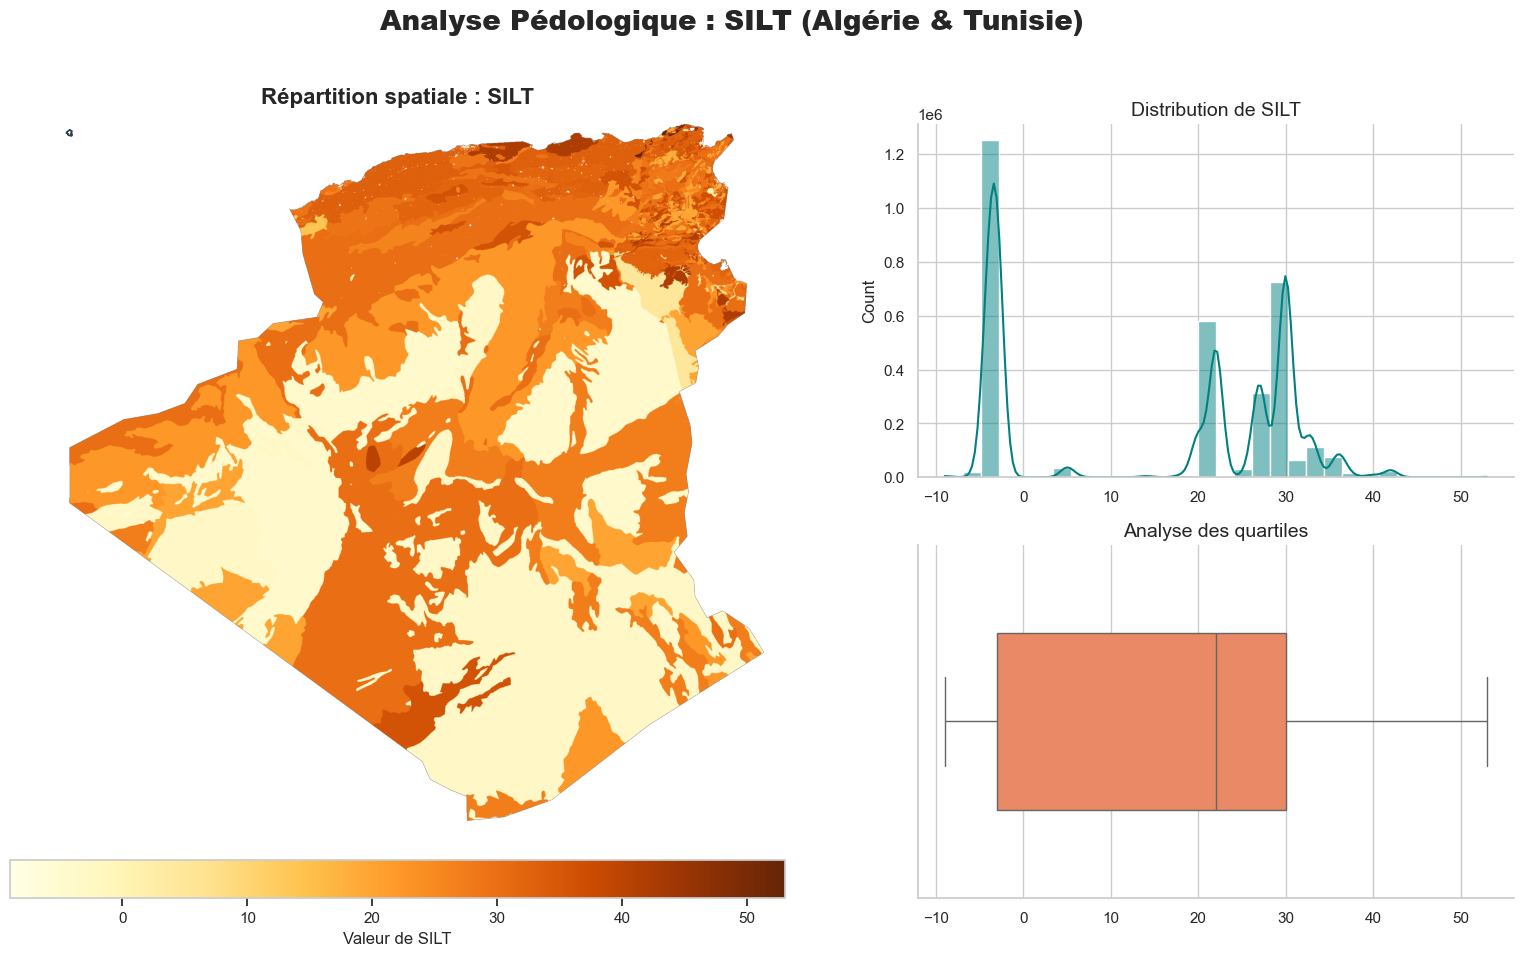

📊 Génération du rapport pour CLAY...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


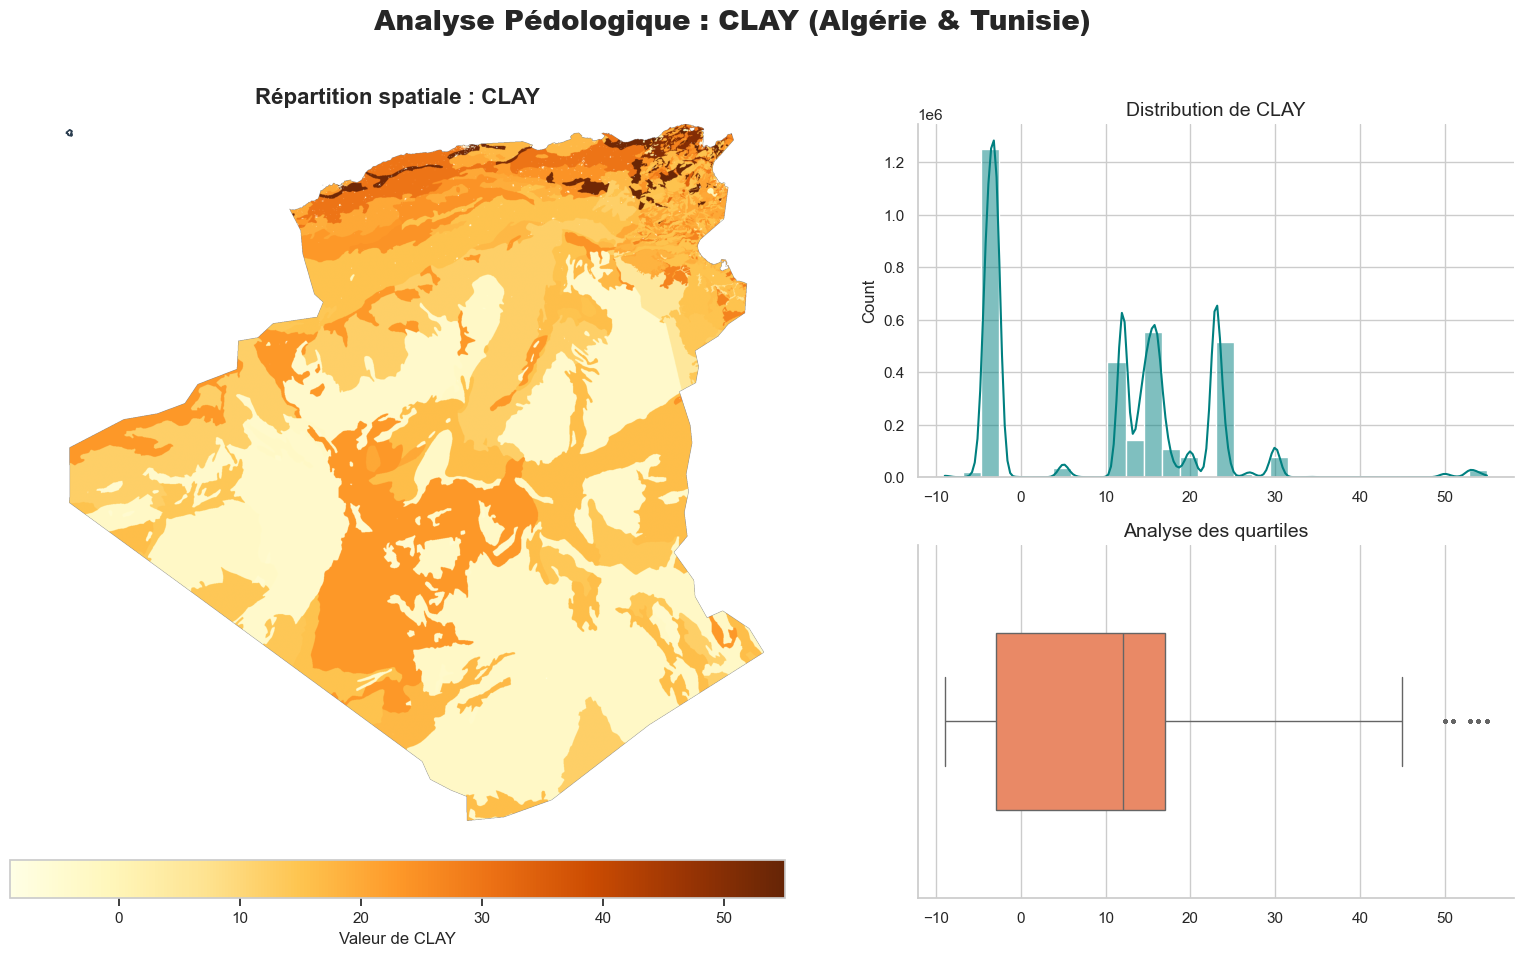

📊 Génération du rapport pour TEXTURE_USDA...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


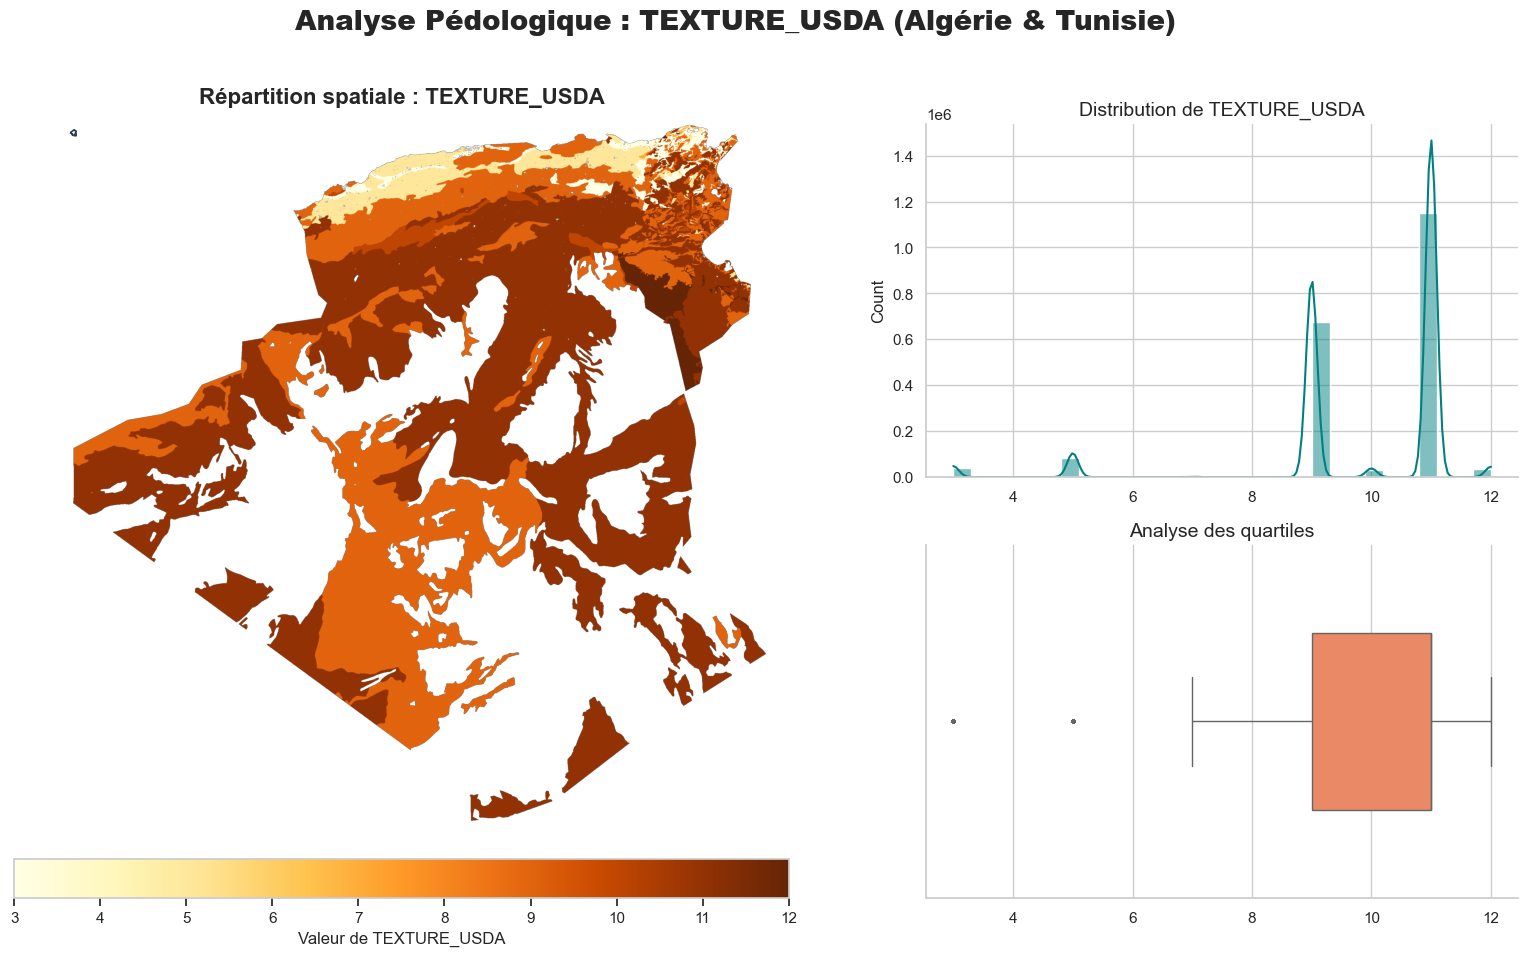

📊 Génération du rapport pour BULK...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


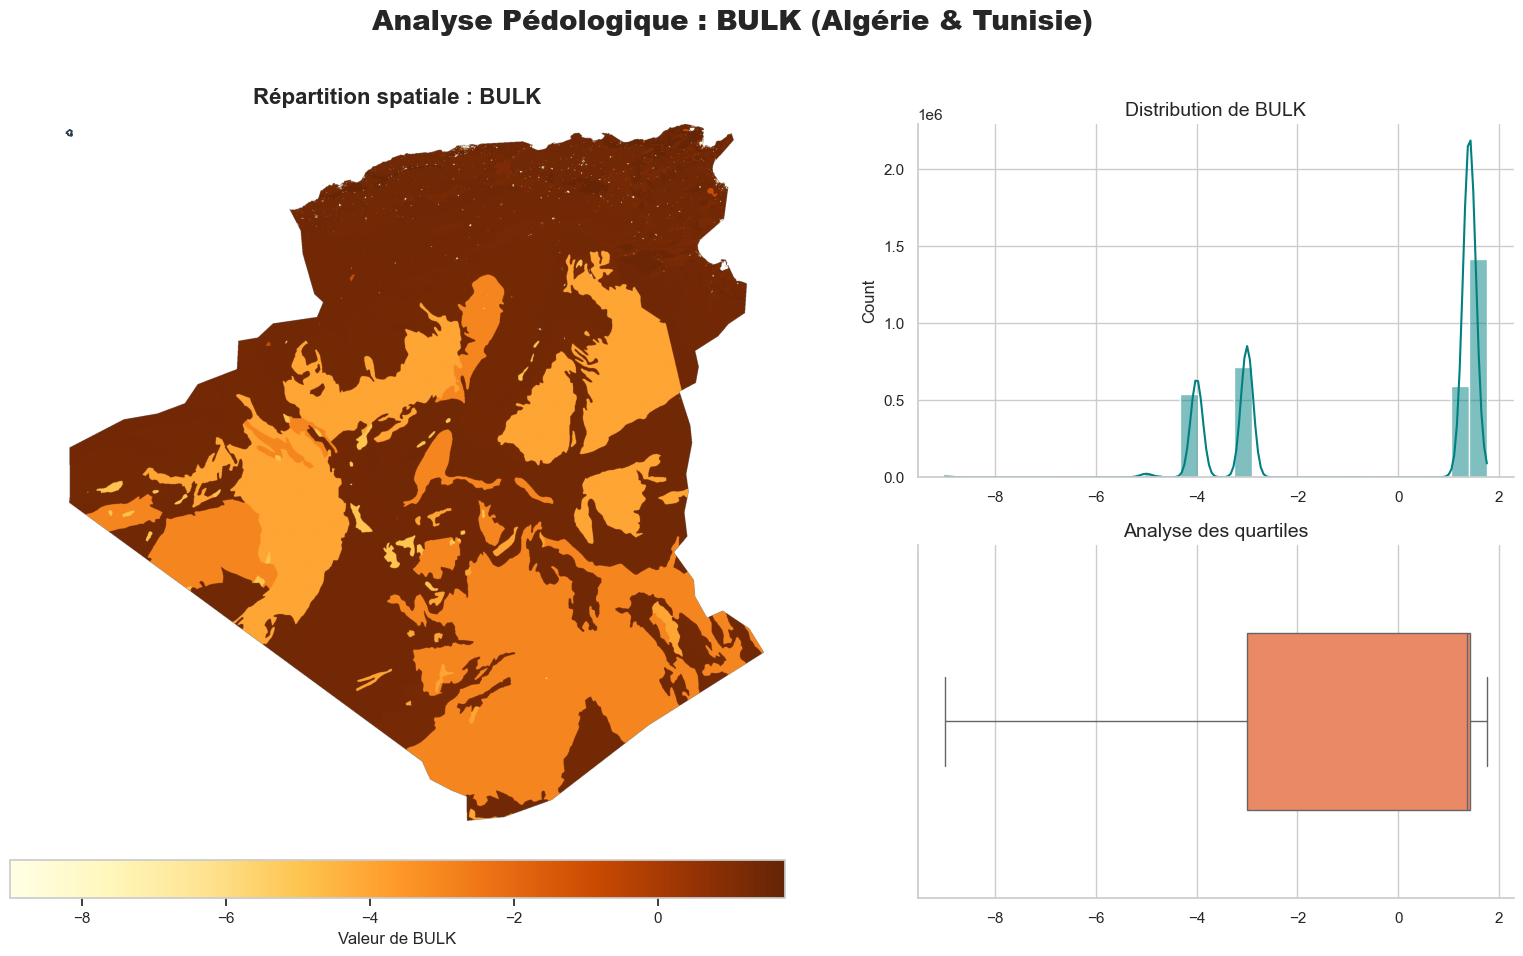

📊 Génération du rapport pour REF_BULK...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


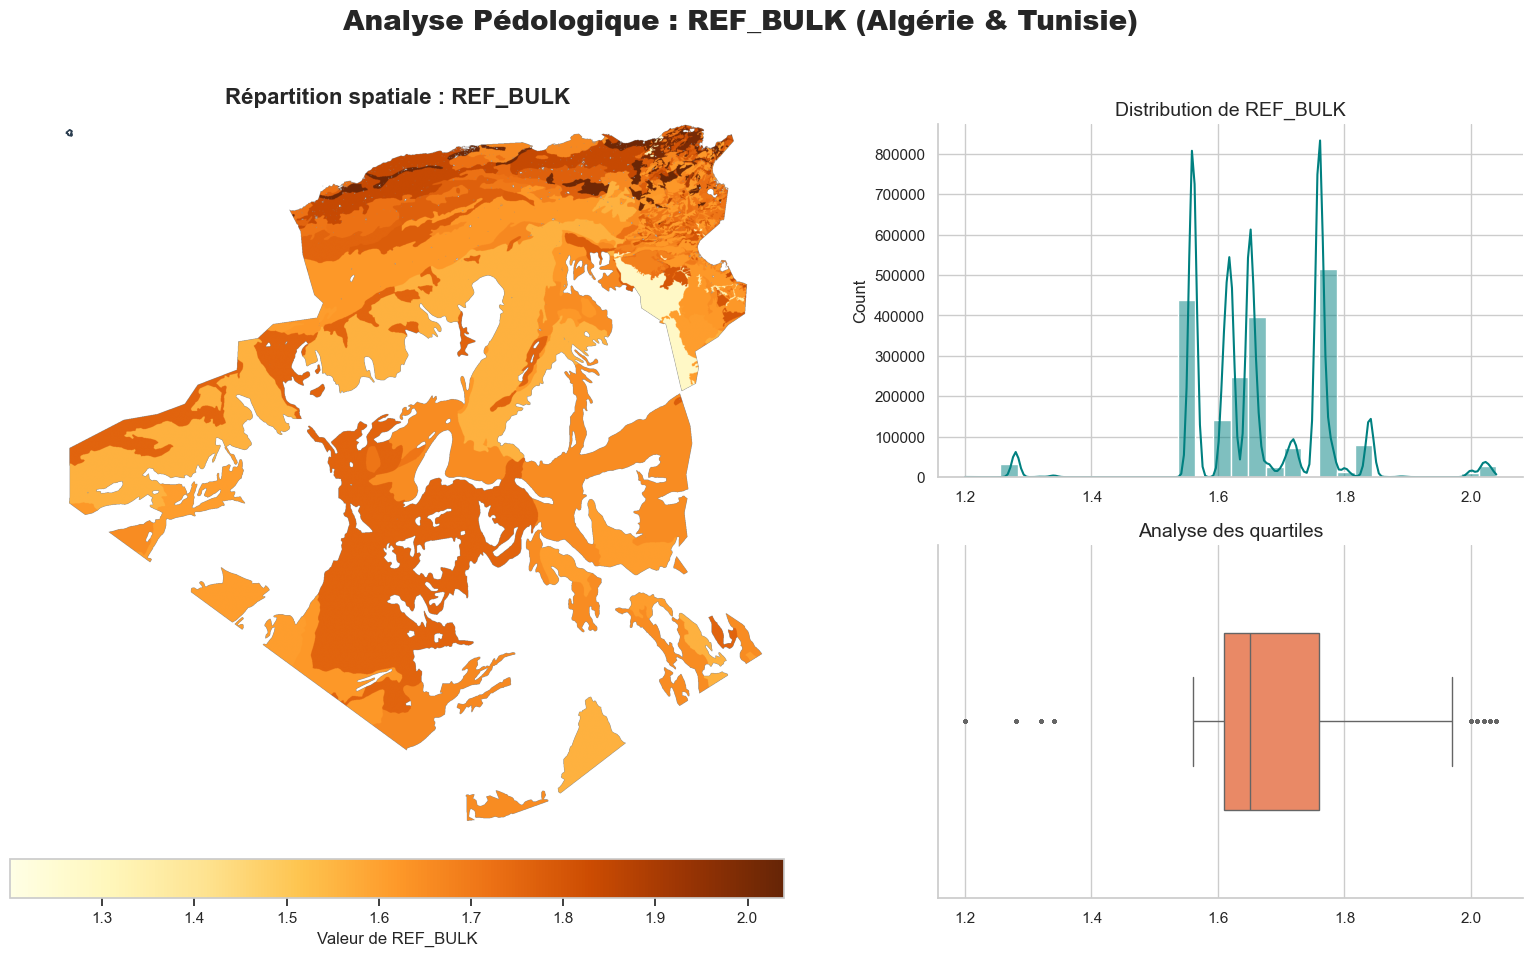

📊 Génération du rapport pour ORG_CARBON...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


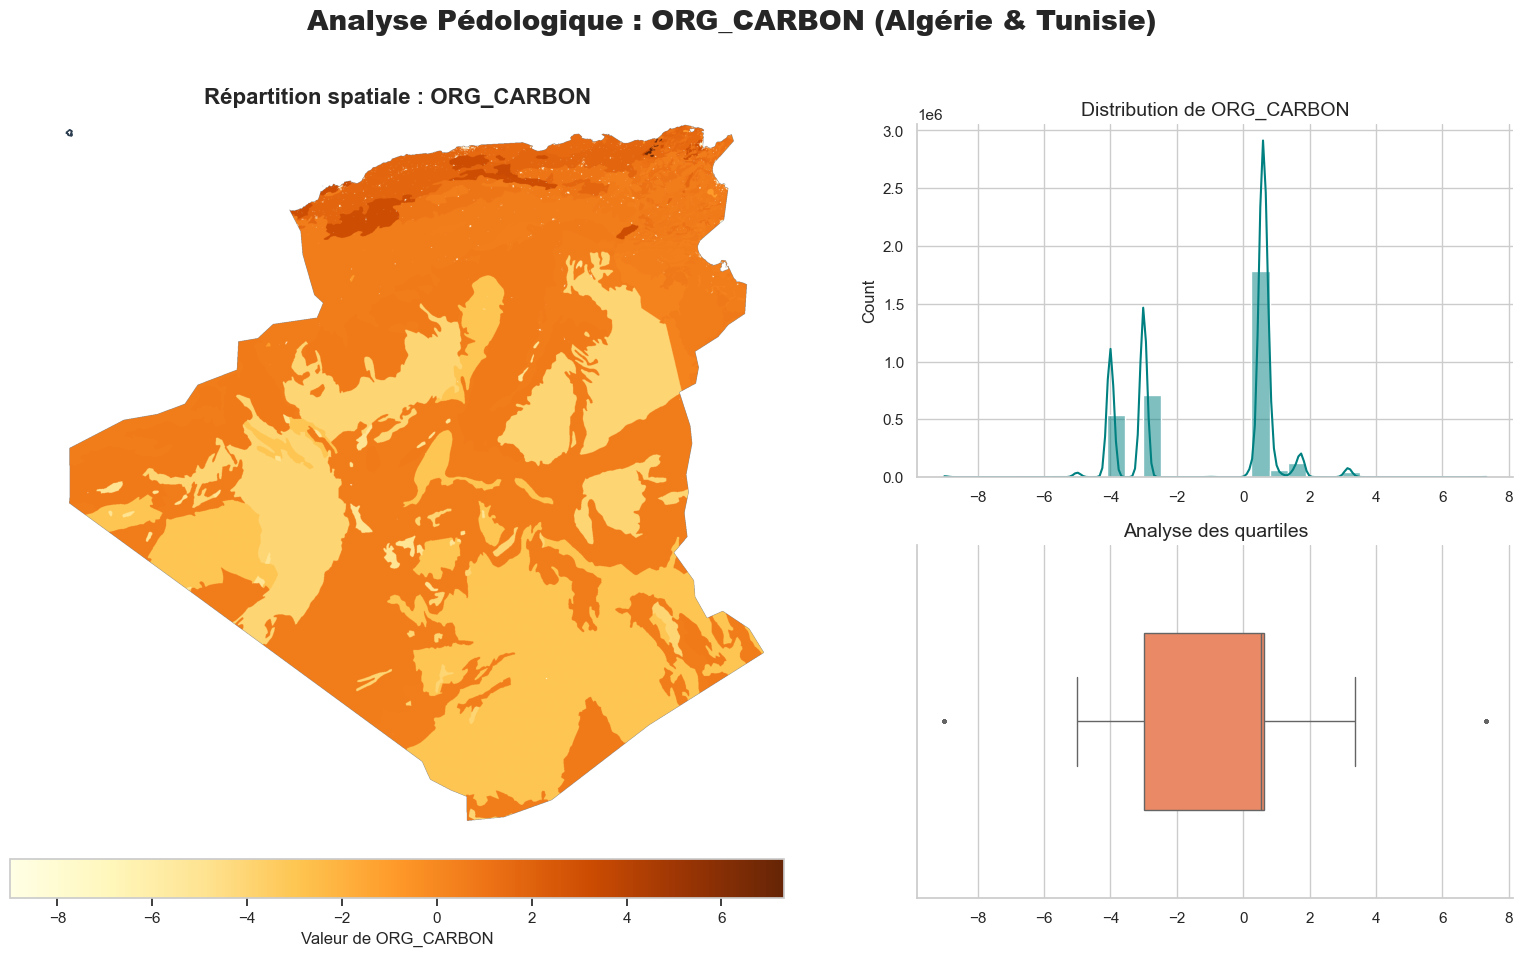

📊 Génération du rapport pour PH_WATER...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


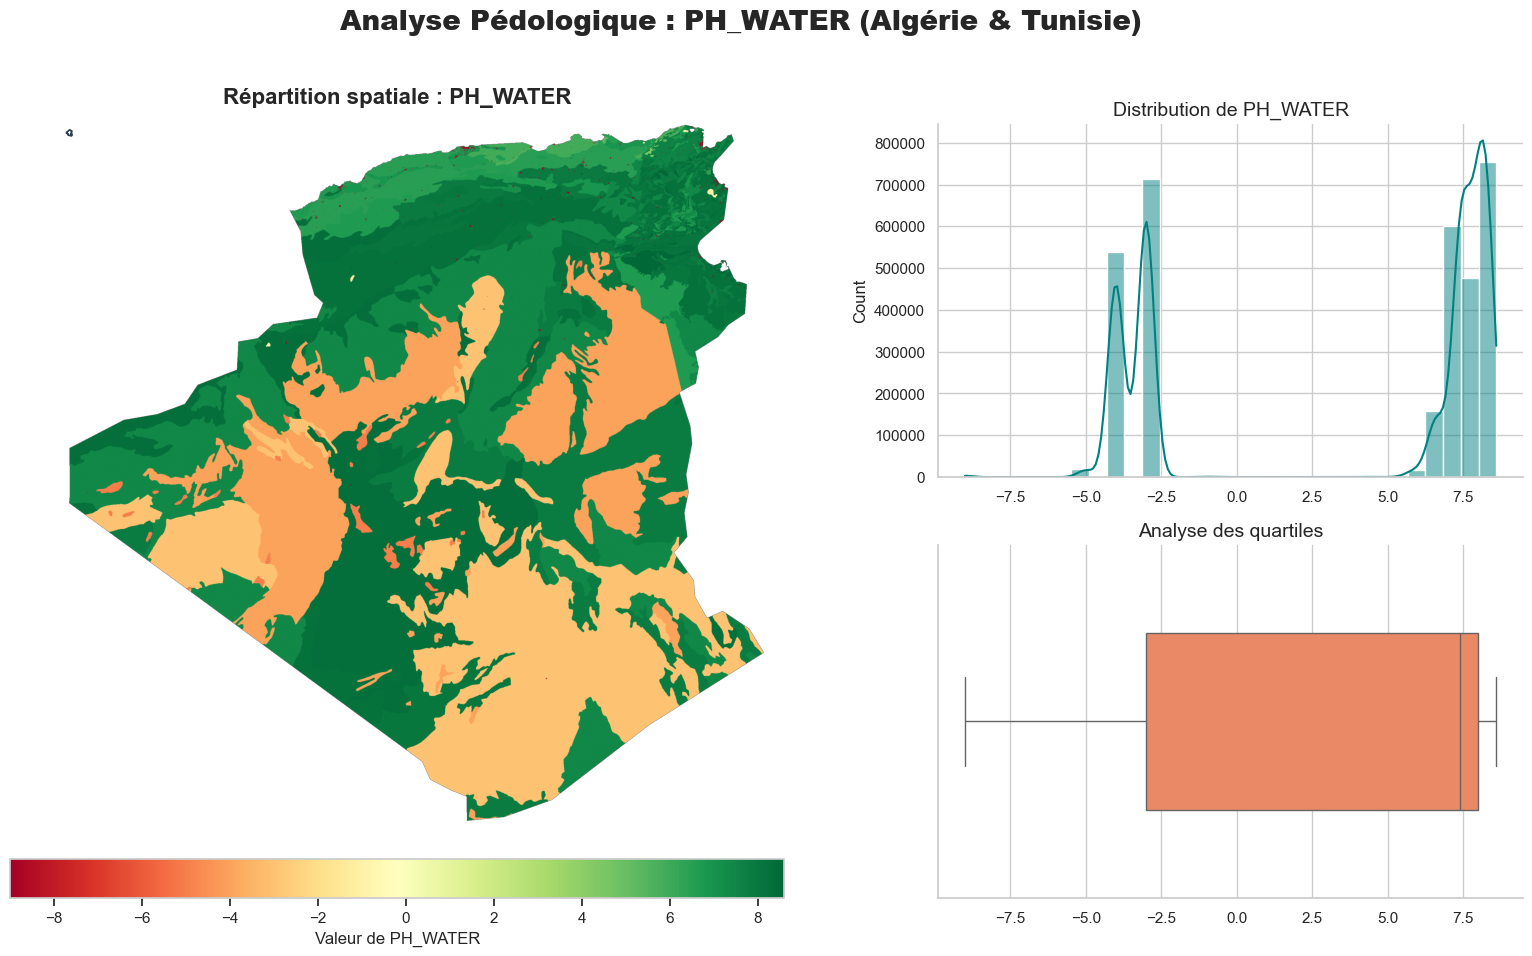

📊 Génération du rapport pour TOTAL_N...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


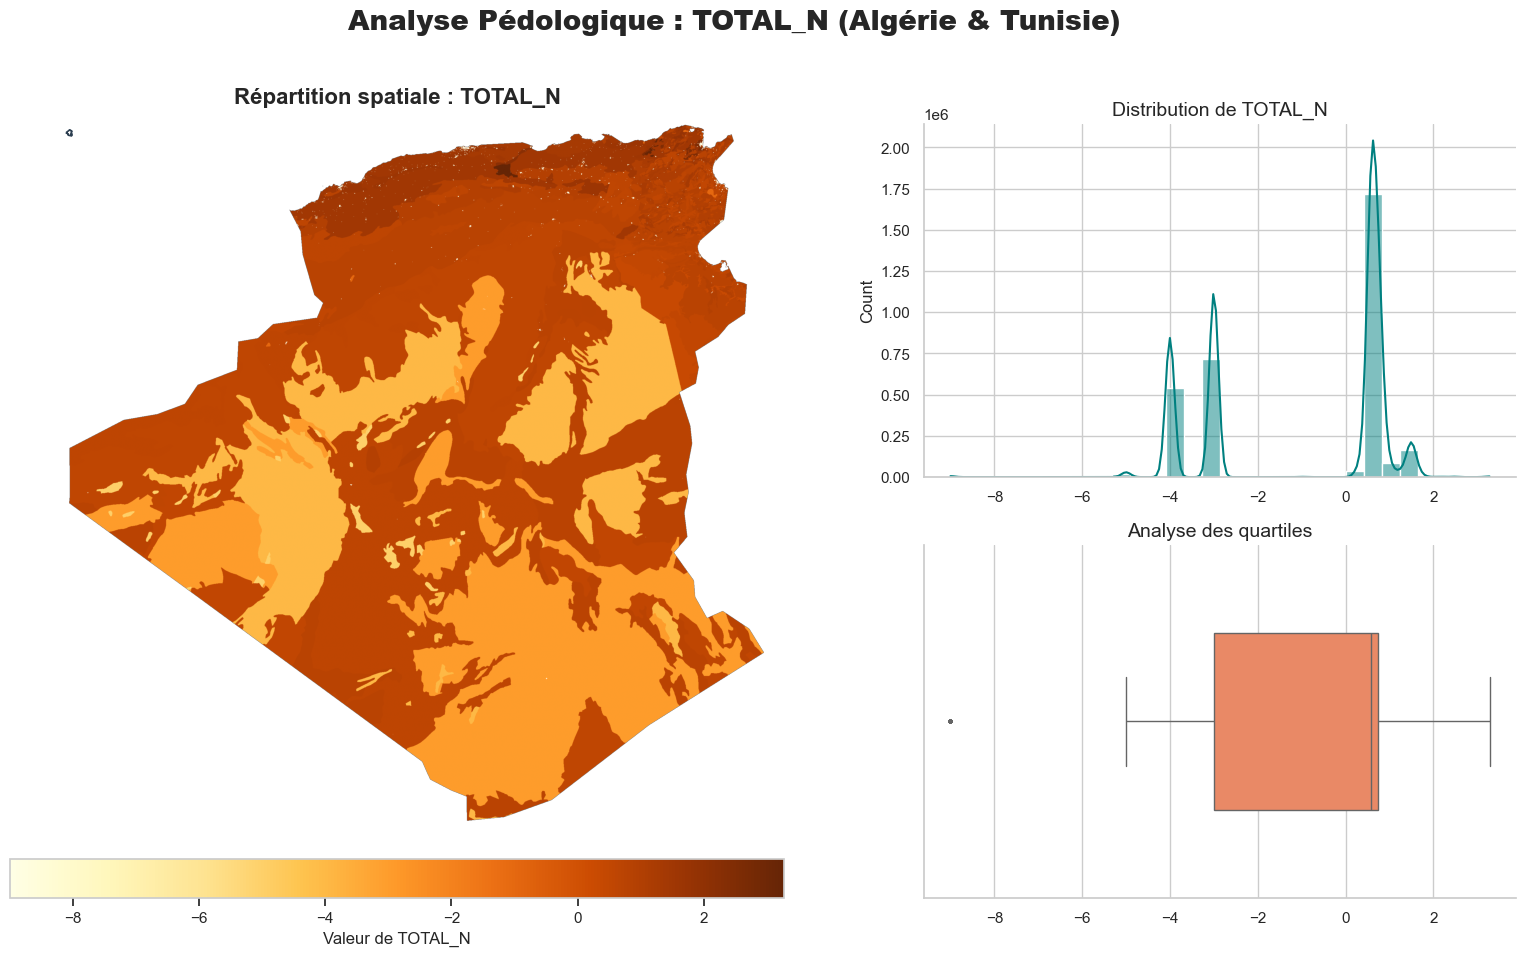

📊 Génération du rapport pour CN_RATIO...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


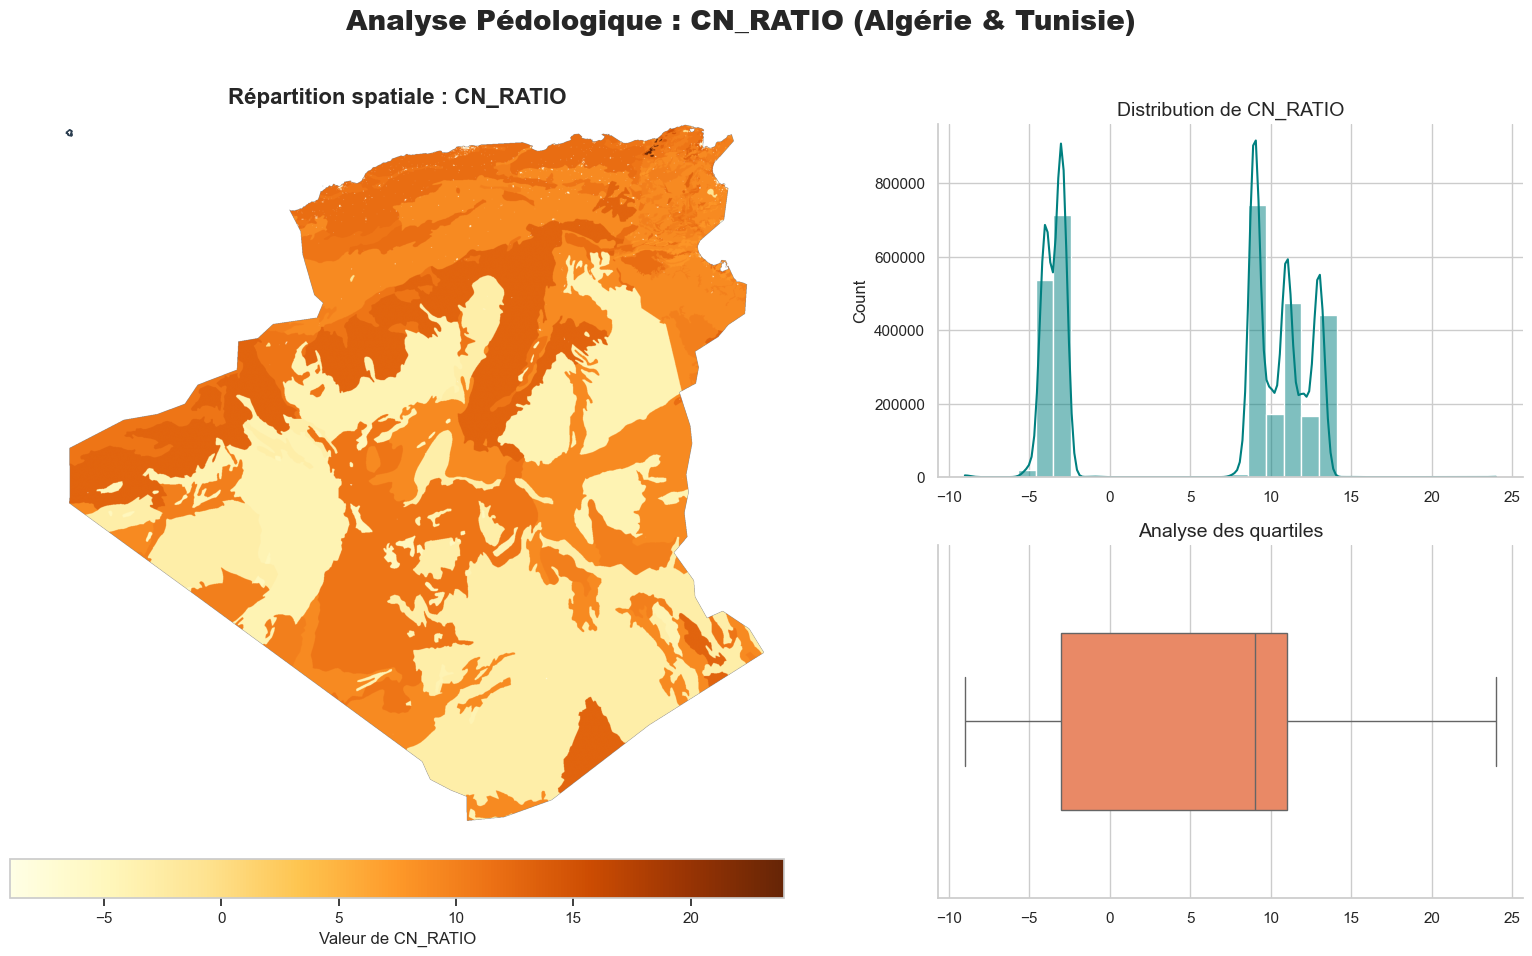

📊 Génération du rapport pour CEC_SOIL...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


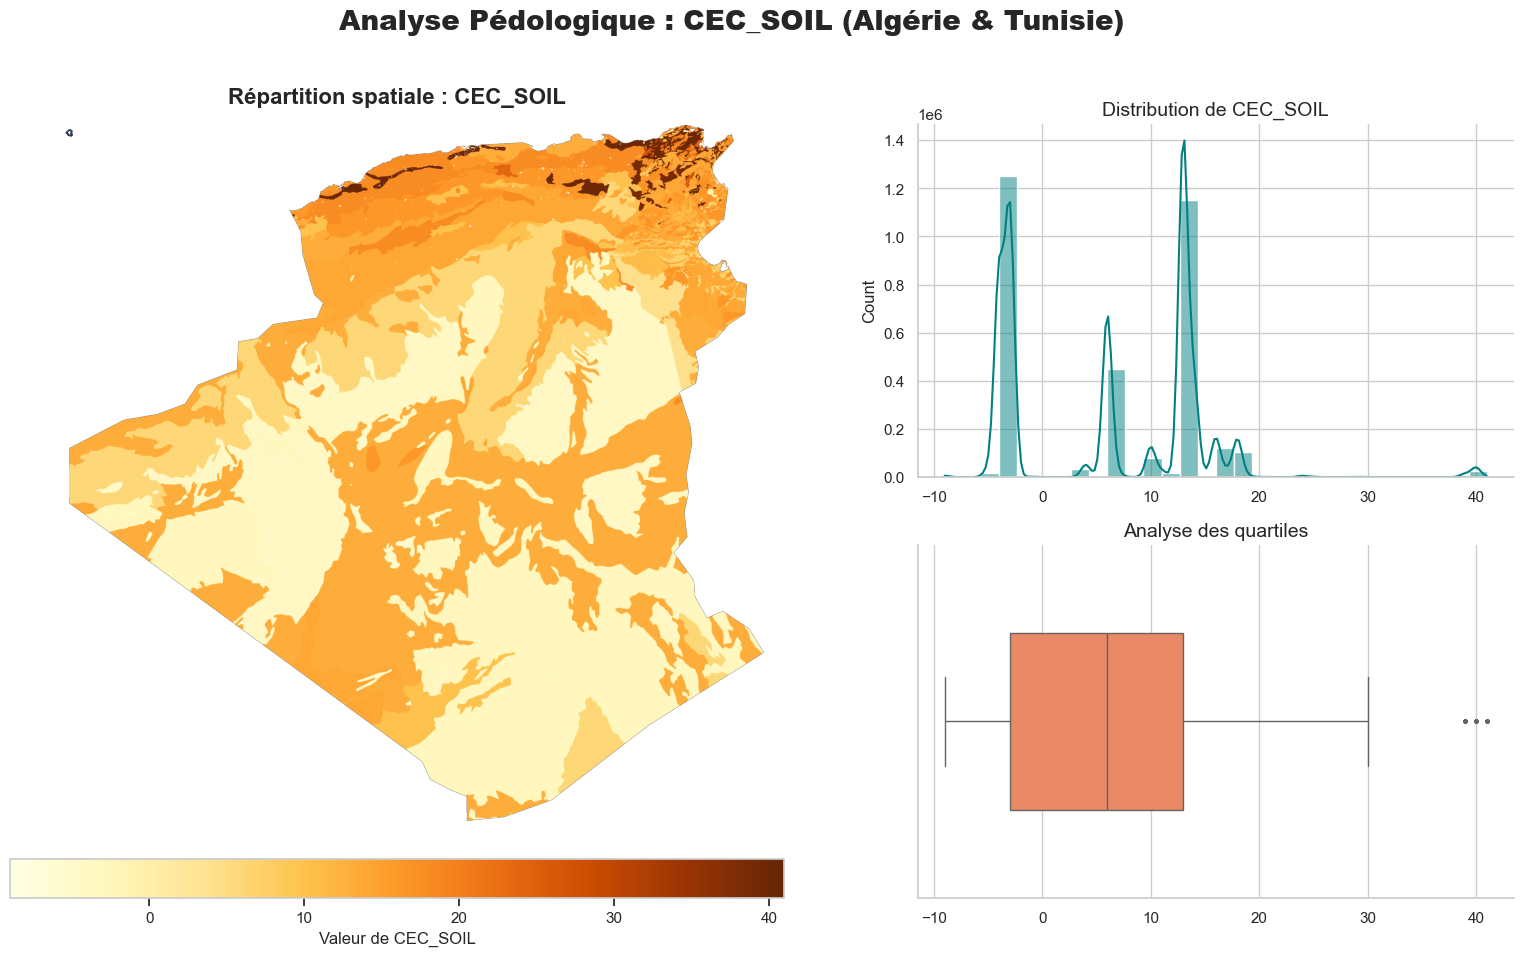

📊 Génération du rapport pour CEC_CLAY...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


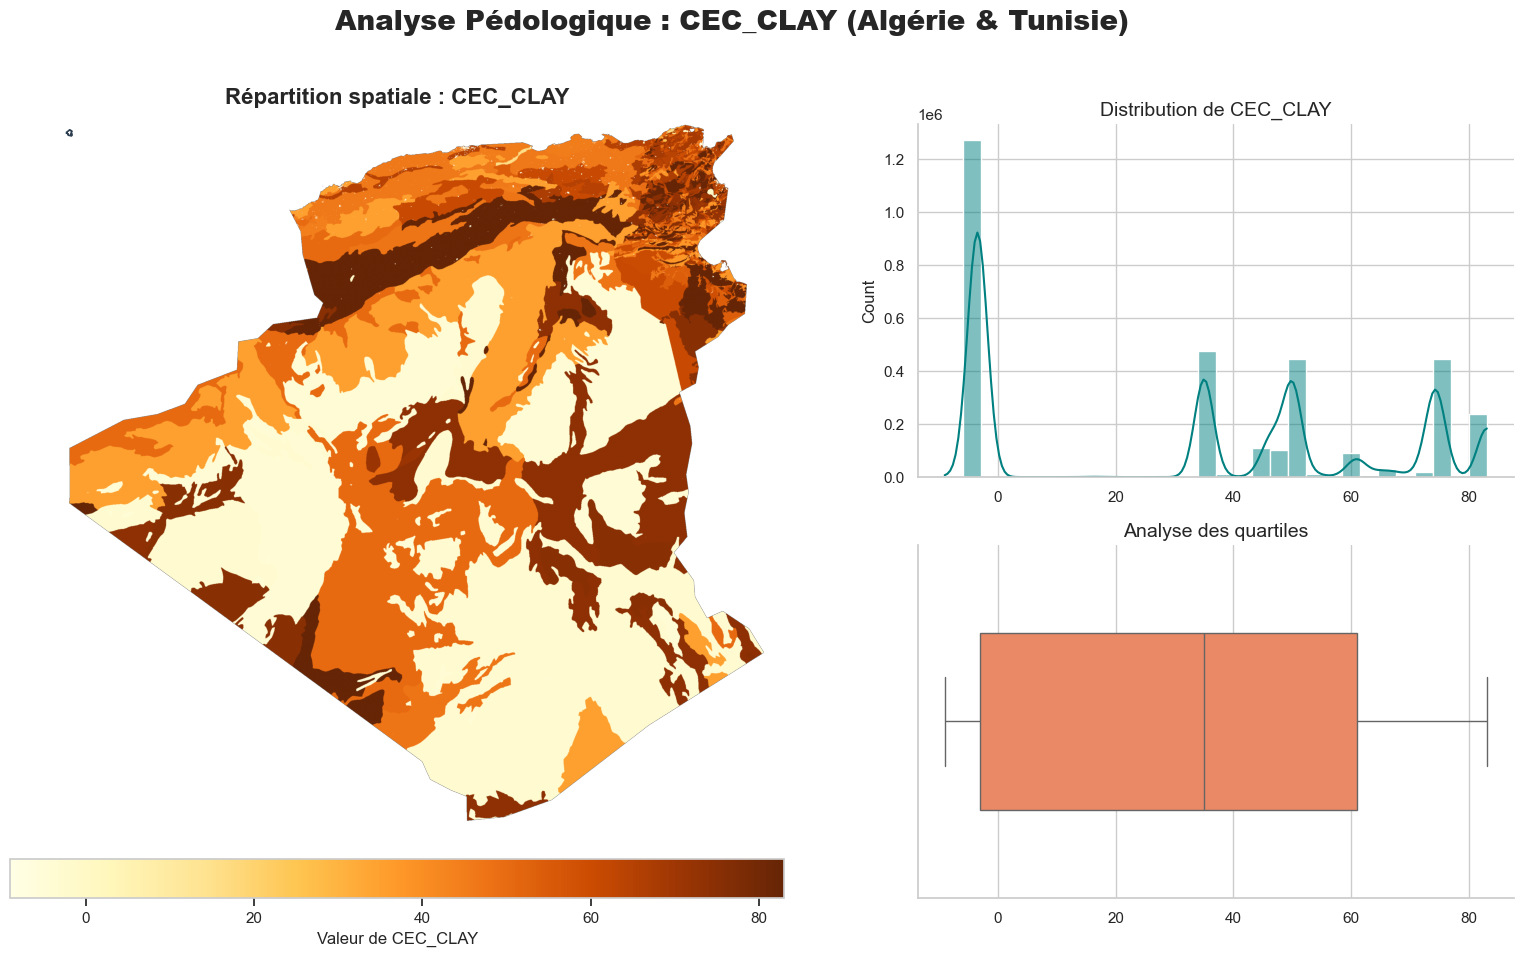

📊 Génération du rapport pour CEC_EFF...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


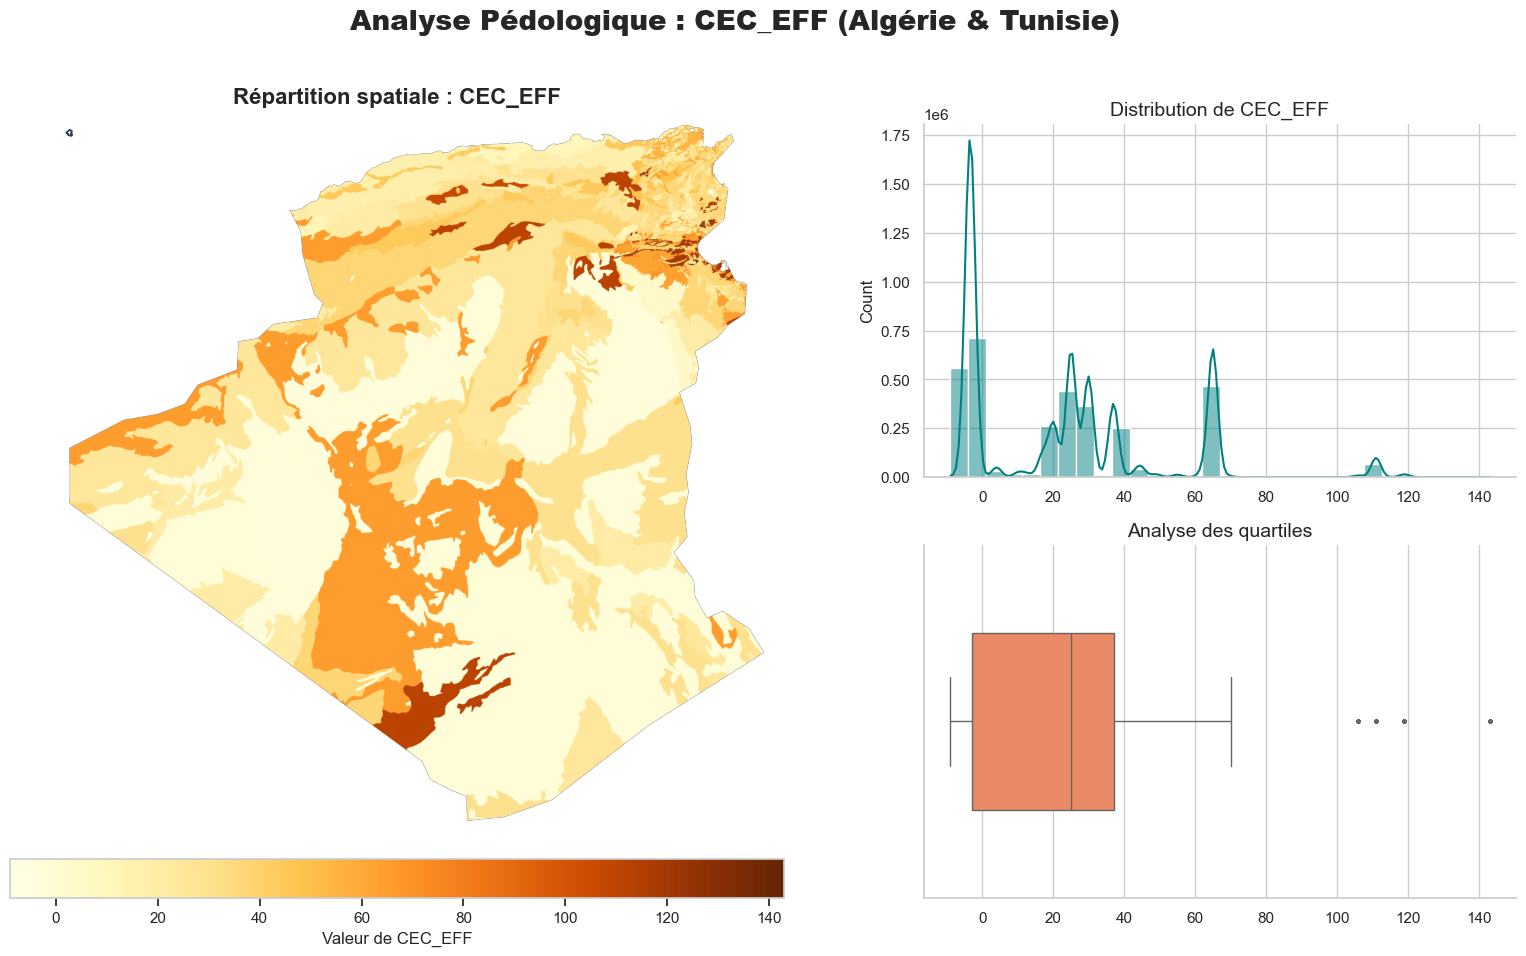

📊 Génération du rapport pour TEB...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


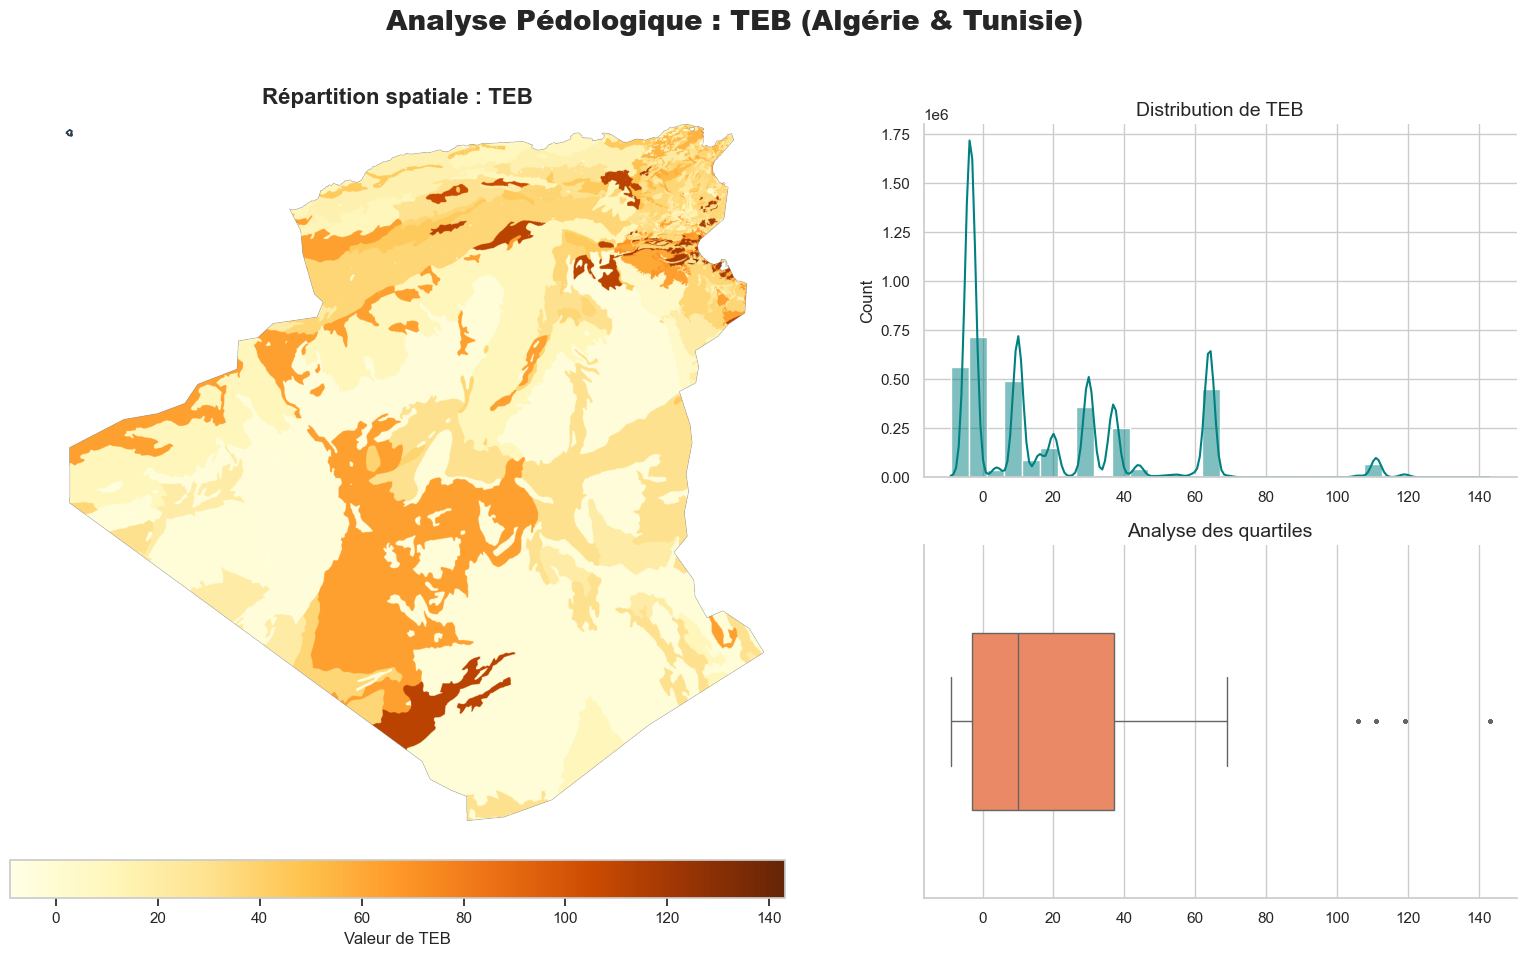

📊 Génération du rapport pour BSAT...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


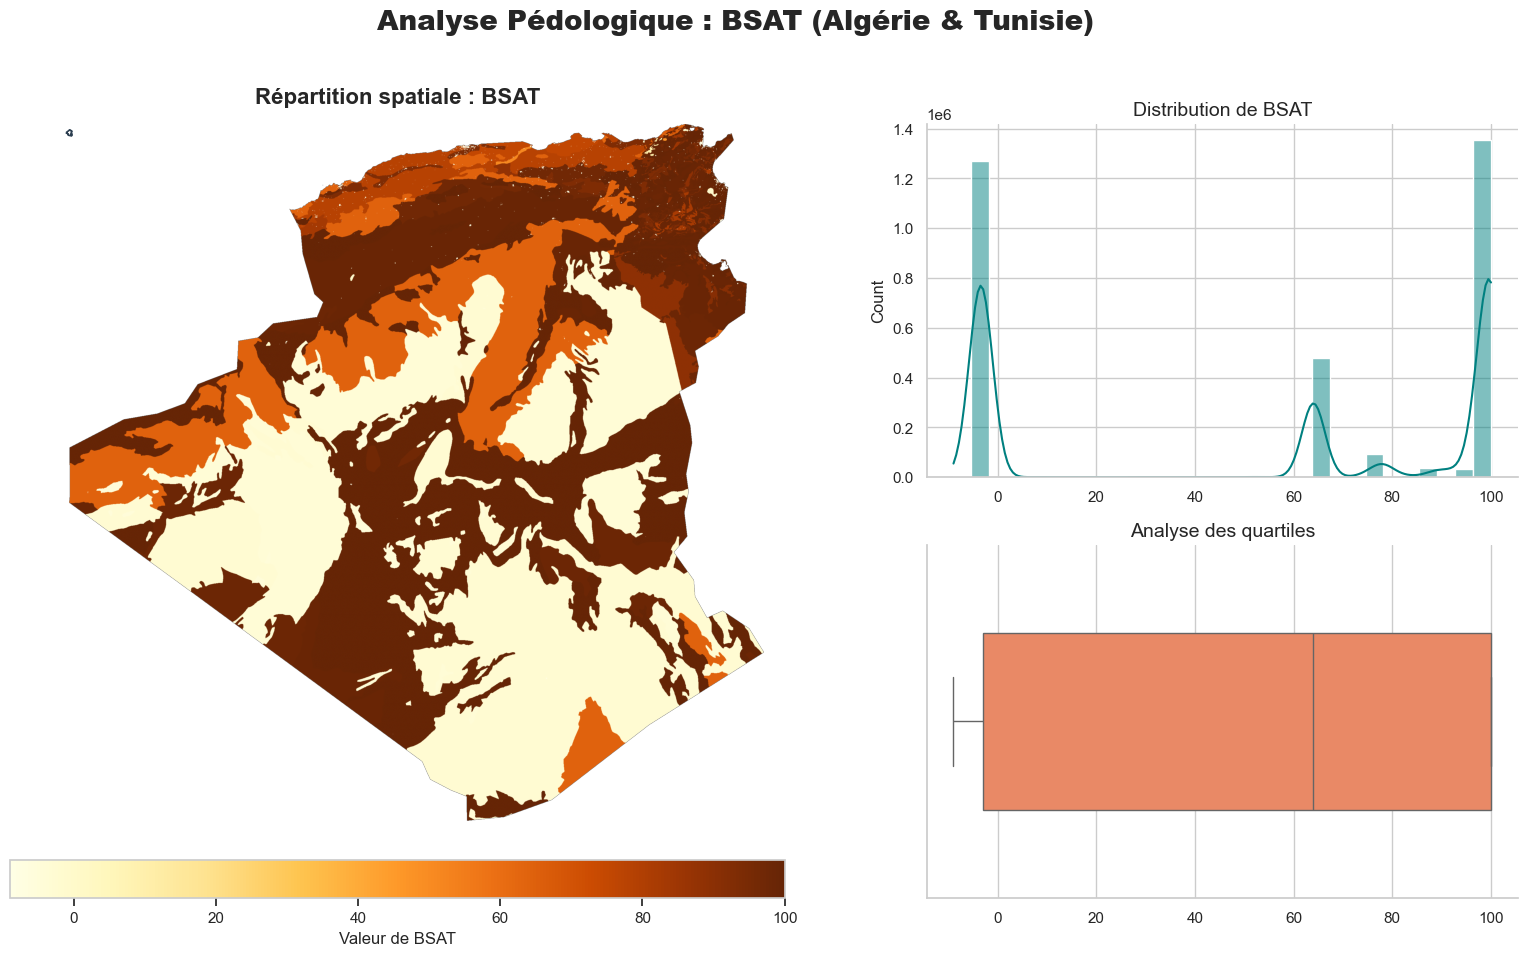

📊 Génération du rapport pour ALUM_SAT...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


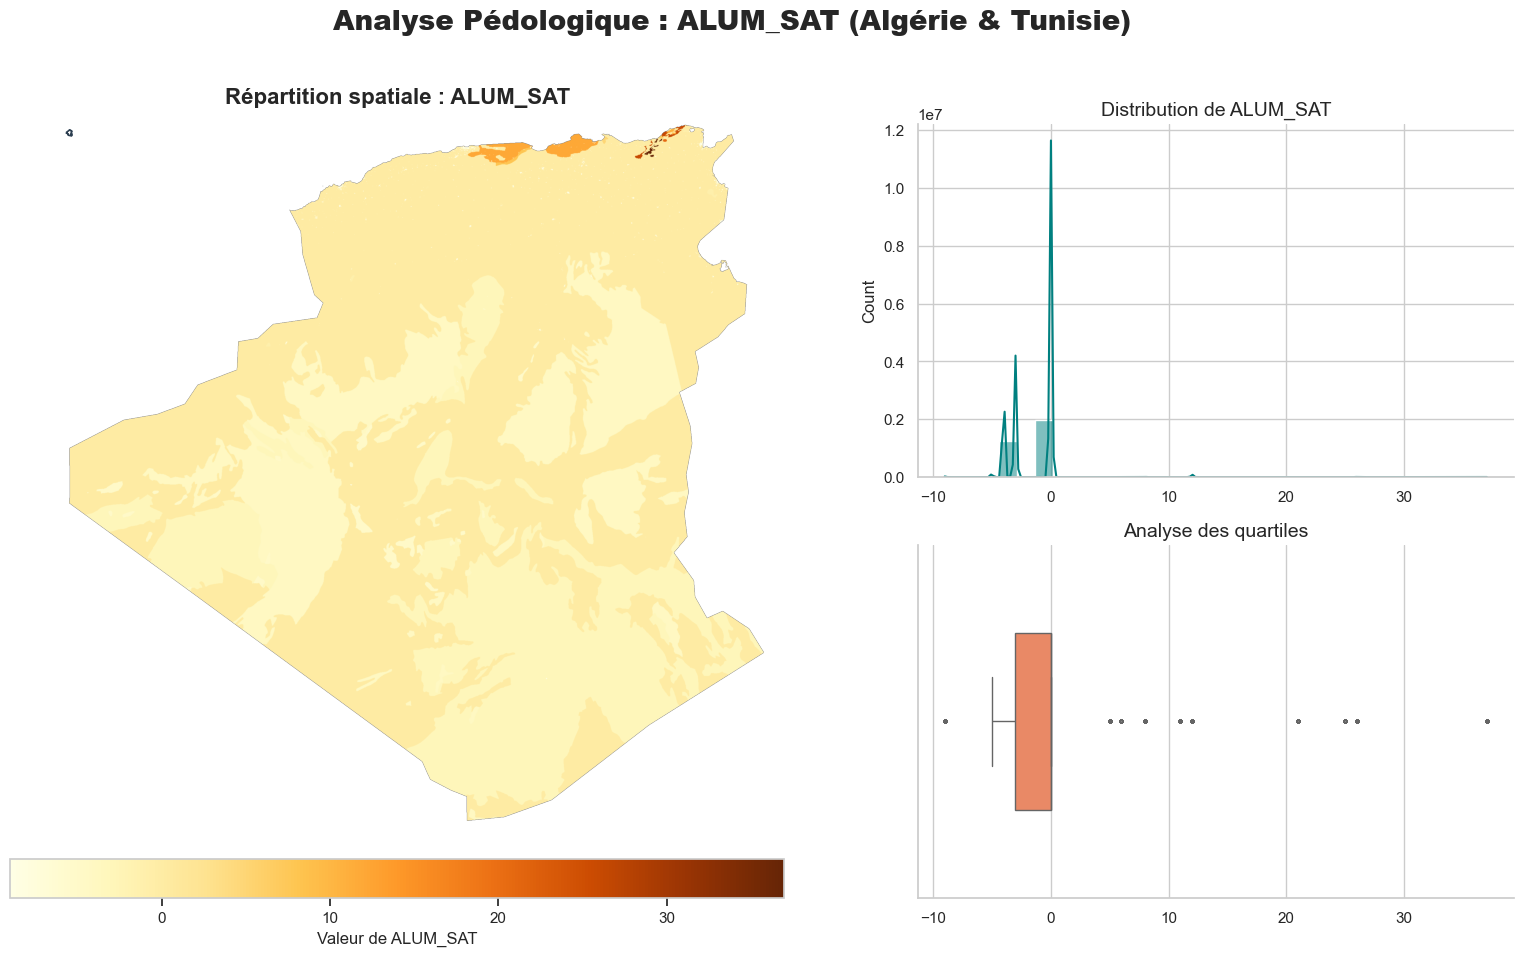

📊 Génération du rapport pour ESP...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


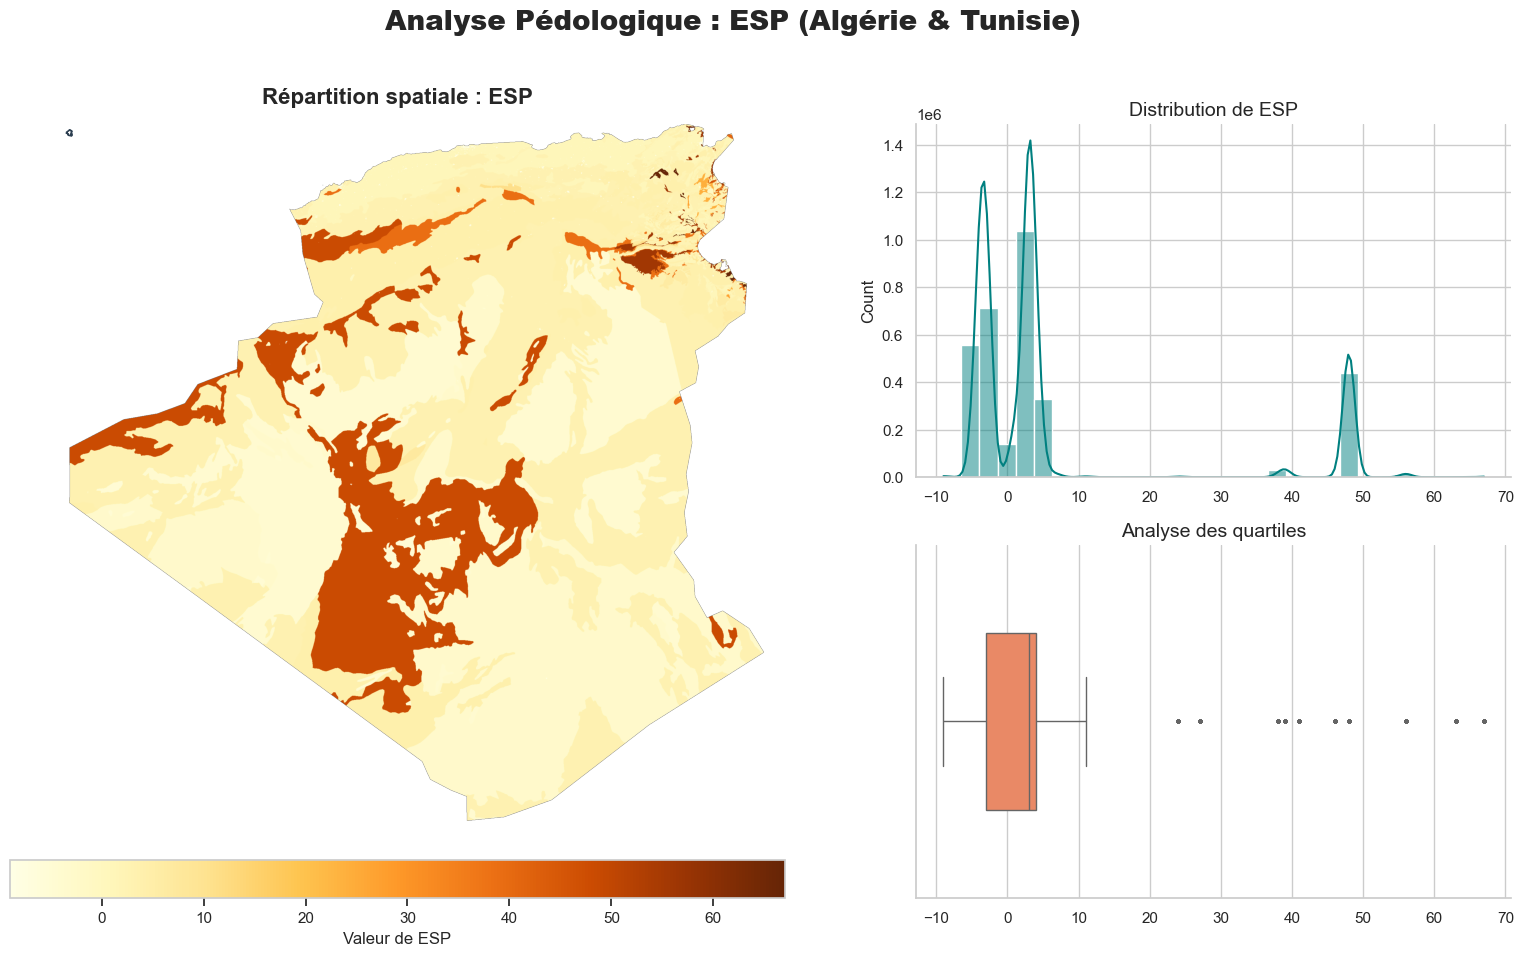

📊 Génération du rapport pour TCARBON_EQ...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


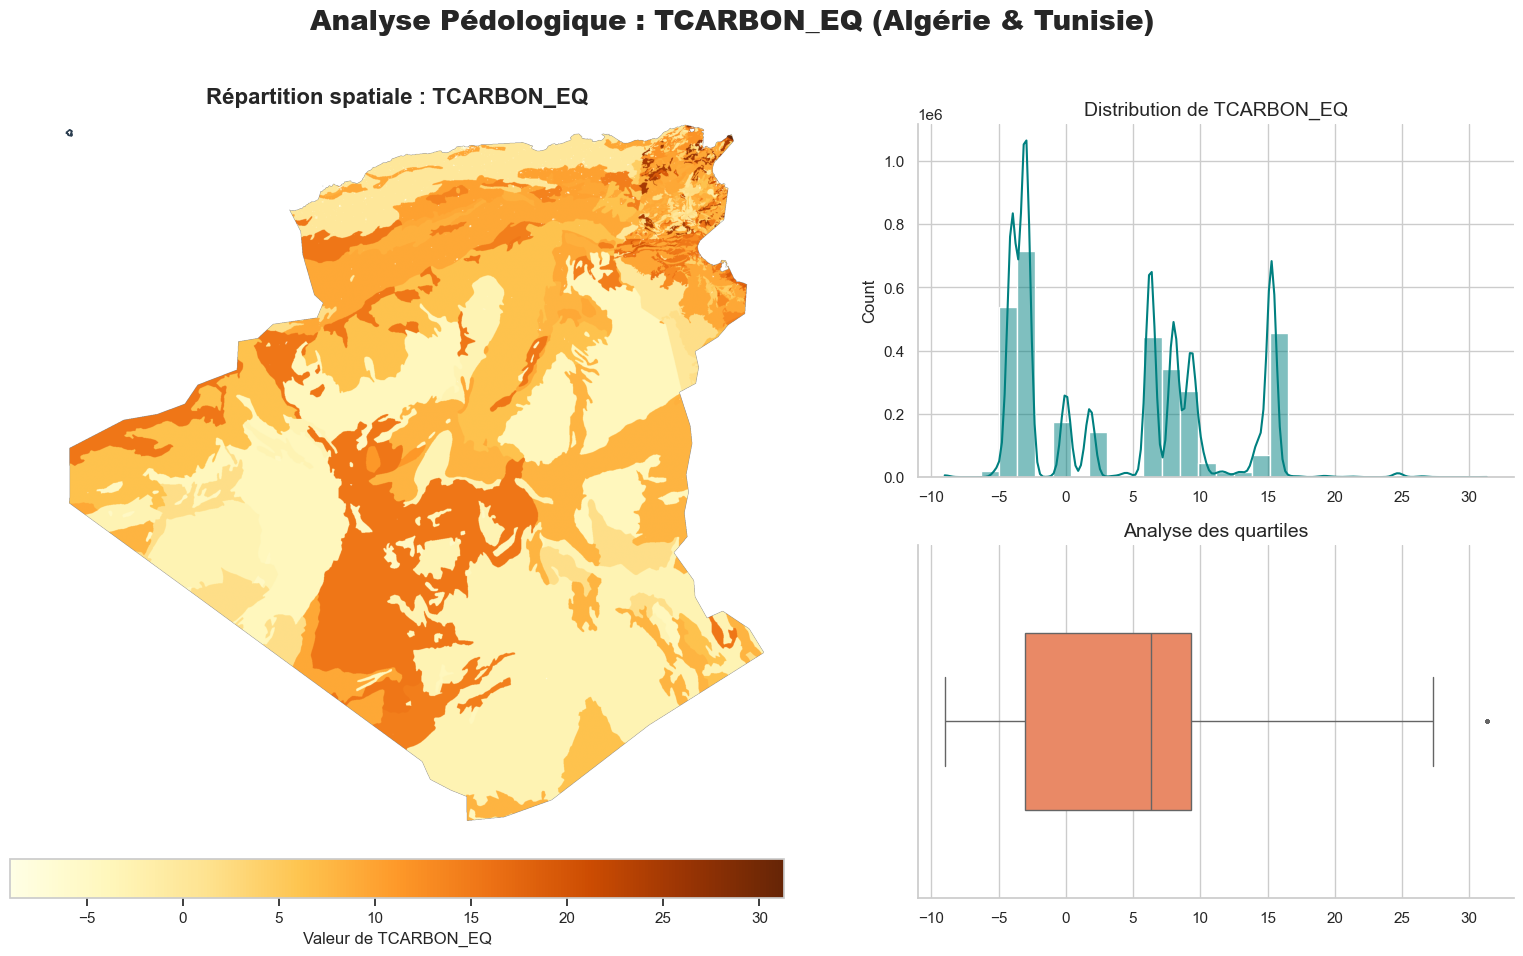

📊 Génération du rapport pour GYPSUM...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


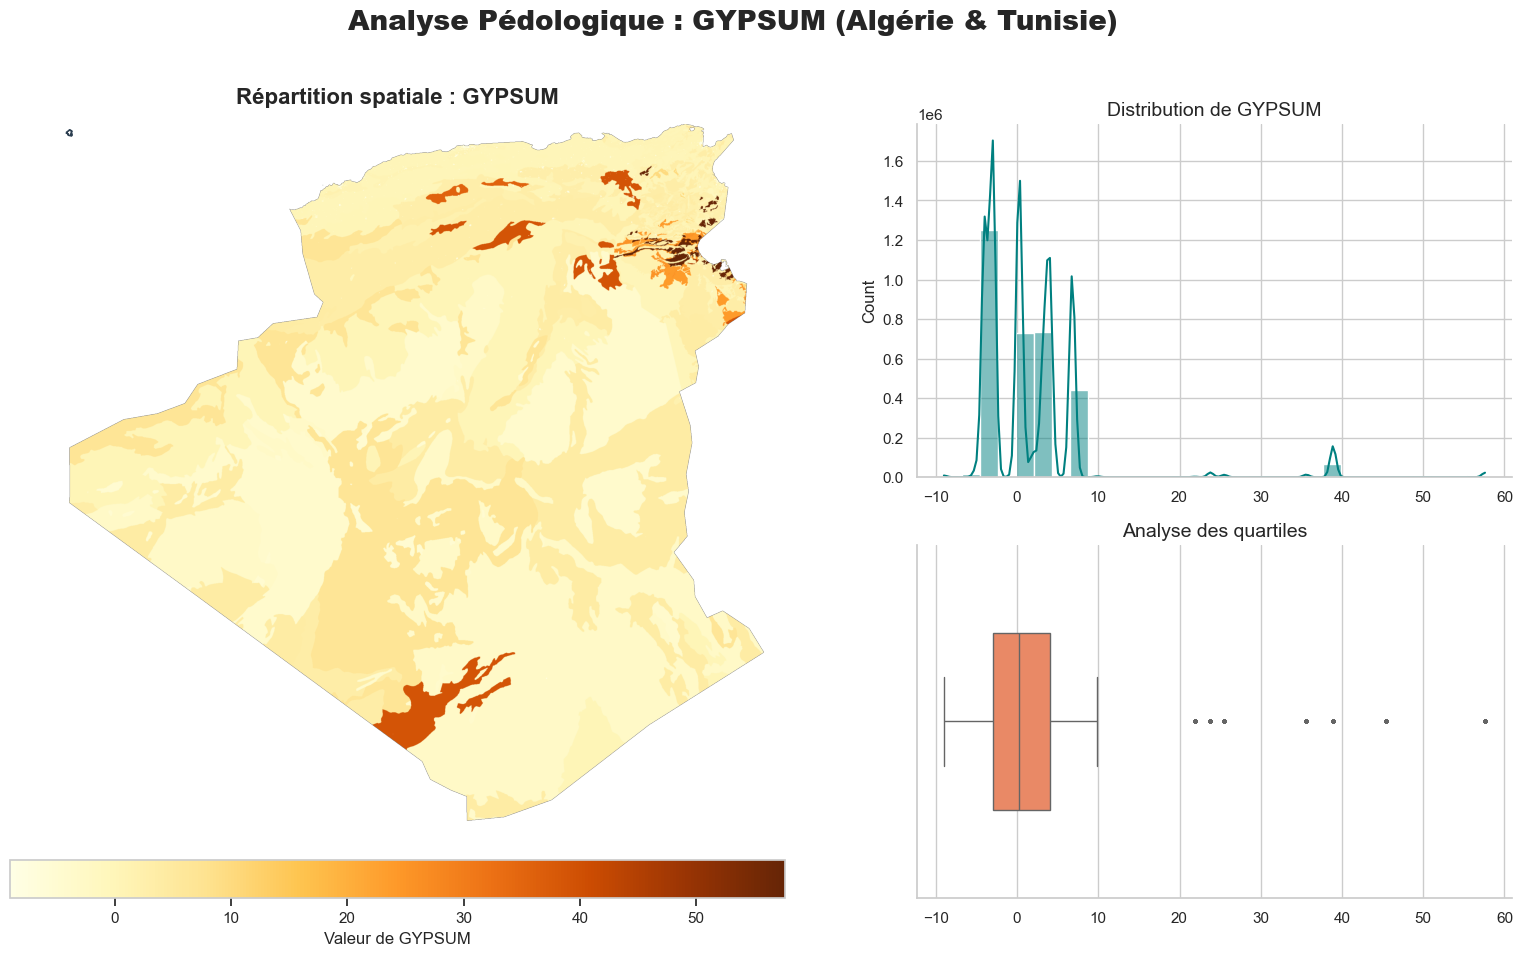

📊 Génération du rapport pour ELEC_COND...


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in get (vectorized)
  outputs = ufunc(*inputs)


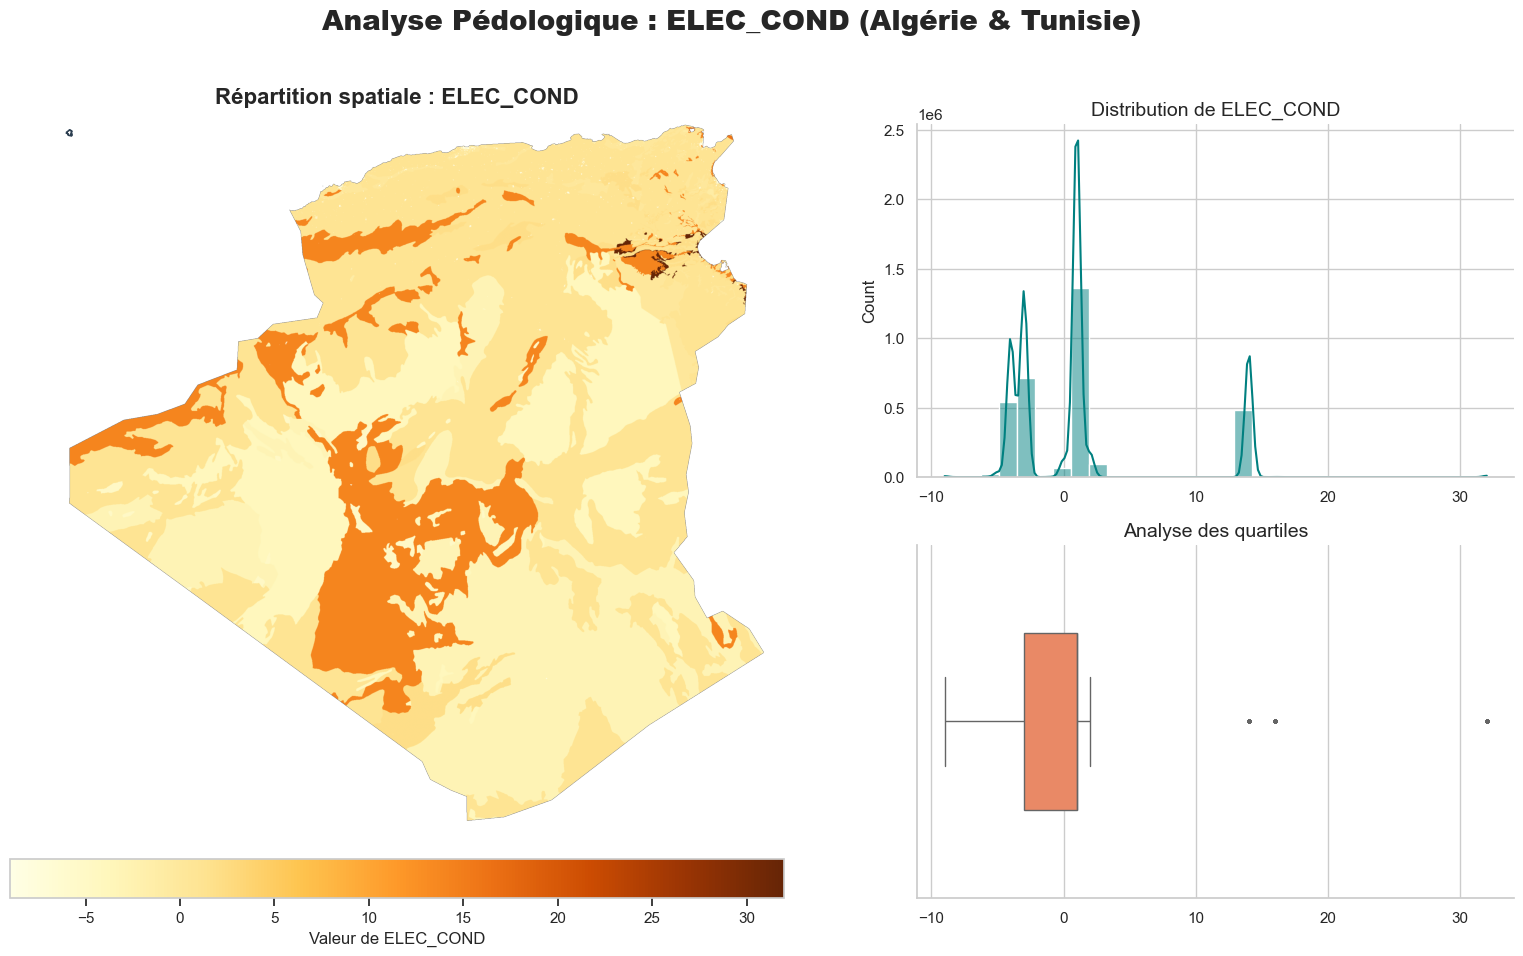

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import mode, skew, kurtosis

def analyze_and_plot_prop(prop, raster_data, borders, df_joined, bins=30):
    # 1. Préparation des données
    lookup = dict(zip(df_joined["HWSD2_SMU_ID"], df_joined[prop]))
    prop_map = np.vectorize(lookup.get)(raster_data).astype(float)
    prop_map = np.ma.masked_invalid(prop_map)
    vals = prop_map.compressed()
    
    if vals.size == 0: return None

    # Choix de la palette selon la propriété
    cmap_dict = {
        'OC': 'Greens',      # Organic Carbon
        'PH': 'RdYlGn',      # pH (Rouge acide, Vert basique)
        'CLAY': 'YlOrBr',    # Argile (Terre)
        'SAND': 'YlOrRd',    # Sable
        'GRAVEL': 'Greys'    # Gravier
    }
    # Utilise 'YlOrBr' par défaut si la clé n'est pas trouvée
    current_cmap = next((cmap_dict[k] for k in cmap_dict if k in prop.upper()), 'YlOrBr')

    # 2. Création d'une figure complexe (GridSpec)
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=[1.5, 1], height_ratios=[1, 1])
    
    # --- A. LA CARTE (Prend toute la colonne de gauche) ---
    ax_map = fig.add_subplot(gs[:, 0])
    img = ax_map.imshow(prop_map, cmap=current_cmap)
    borders.boundary.plot(ax=ax_map, color="#2c3e50", linewidth=1.2, zorder=3)
    
    ax_map.set_title(f"Répartition spatiale : {prop}", fontsize=16, fontweight='bold', pad=15)
    ax_map.set_axis_off()
    
    # Barre de couleur horizontale en bas de la carte
    cbar = fig.colorbar(img, ax=ax_map, orientation='horizontal', fraction=0.05, pad=0.05)
    cbar.set_label(f"Valeur de {prop}", fontsize=12)

    # --- B. HISTOGRAMME + KDE (En haut à droite) ---
    ax_hist = fig.add_subplot(gs[0, 1])
    sns.histplot(vals, bins=bins, kde=True, color="teal", ax=ax_hist, edgecolor='white')
    ax_hist.set_title(f"Distribution de {prop}", fontsize=14)
    sns.despine(ax=ax_hist)

    # --- C. BOXPLOT (En bas à droite) ---
    ax_box = fig.add_subplot(gs[1, 1])
    sns.boxplot(x=vals, color="coral", ax=ax_box, width=0.5, fliersize=2)
    ax_box.set_title(f"Analyse des quartiles", fontsize=14)
    sns.despine(ax=ax_box)

    plt.suptitle(f"Analyse Pédologique : {prop} (Algérie & Tunisie)", fontsize=20, y=0.98, fontweight='black')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # 3. Calcul des statistiques (retournées pour le CSV)
    stats = {
        "count": int(vals.size), "mean": np.mean(vals), "median": np.median(vals),
        "min": np.min(vals), "max": np.max(vals), "std": np.std(vals),
        "skewness": skew(vals), "kurtosis": kurtosis(vals)
    }
    
    plt.show()
    return stats

# --- Lancement du traitement ---
# Assurez-vous que numeric_props contient les colonnes de df_joined que vous voulez cartographier
results = {}
for prop in numeric_props:
    print(f"📊 Génération du rapport pour {prop}...")
    stats = analyze_and_plot_prop(prop, raster_data, north_africa, df_joined)
    if stats:
        results[prop] = stats

Construction de la matrice de corrélation spatiale...
Nombre de SMU pour l'analyse: 841
Propriétés analysées: 21

Aperçu de la matrice de corrélation:
                COARSE      SAND      SILT      CLAY  TEXTURE_USDA      BULK  \
COARSE        1.000000  0.280086 -0.316668 -0.162698      0.209145 -0.366114   
SAND          0.280086  1.000000 -0.768320 -0.864949      0.868457 -0.240606   
SILT         -0.316668 -0.768320  1.000000  0.343333     -0.469100 -0.039893   
CLAY         -0.162698 -0.864949  0.343333  1.000000     -0.906538  0.384338   
TEXTURE_USDA  0.209145  0.868457 -0.469100 -0.906538      1.000000 -0.304951   

              REF_BULK  ORG_CARBON  PH_WATER   TOTAL_N  ...  CEC_SOIL  \
COARSE       -0.067111    0.117879  0.024610  0.082864  ... -0.144154   
SAND         -0.898730   -0.375511  0.023368 -0.567106  ... -0.780869   
SILT          0.495979    0.256504  0.118732  0.410283  ...  0.301175   
CLAY          0.929884    0.349895 -0.127384  0.510461  ...  0.909680   
TEX

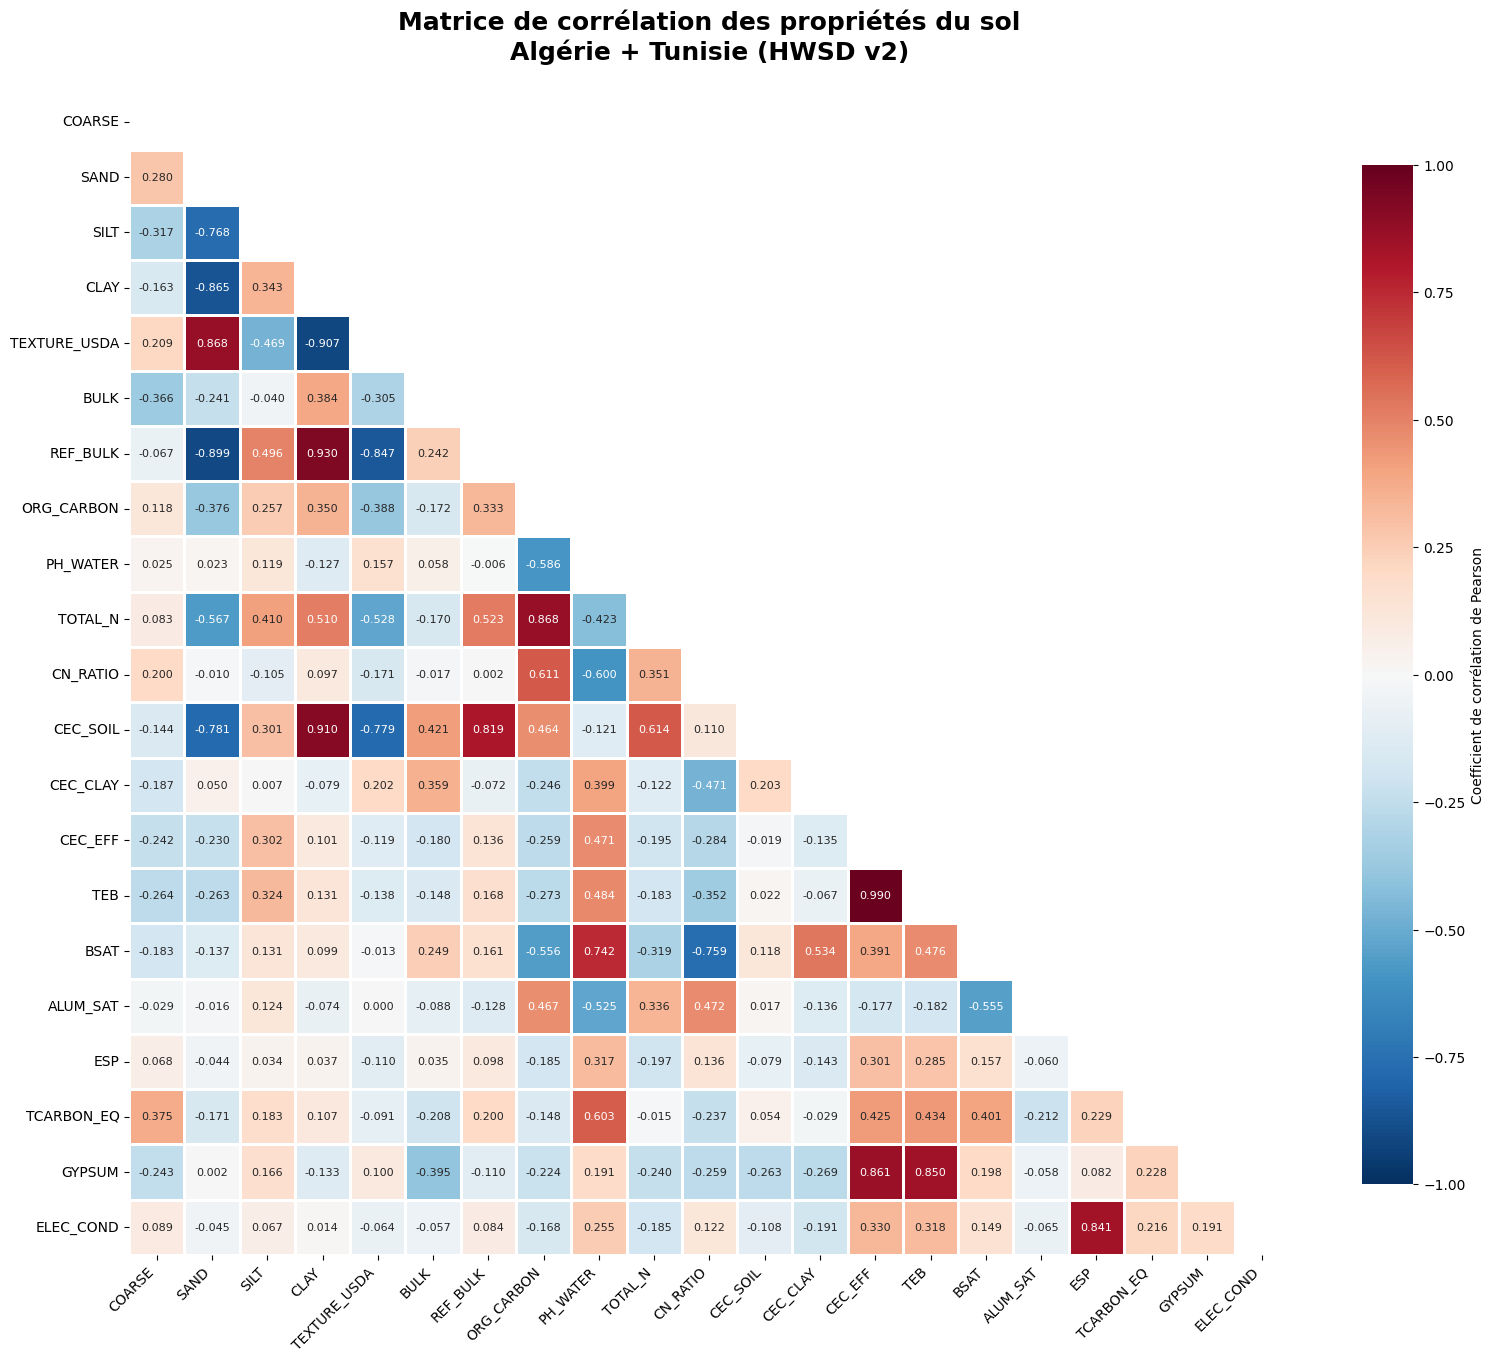


ANALYSE DES CORRÉLATIONS

🔴 CORRÉLATIONS TRÈS FORTES (|r| > 0.9): 4
  • CEC_EFF ↔ TEB: r = 0.990
  • CLAY ↔ REF_BULK: r = 0.930
  • CLAY ↔ CEC_SOIL: r = 0.910
  • CLAY ↔ TEXTURE_USDA: r = -0.907

🟠 CORRÉLATIONS FORTES (0.7 < |r| ≤ 0.9): 14
  • SAND ↔ REF_BULK: r = -0.899
  • SAND ↔ TEXTURE_USDA: r = 0.868
  • ORG_CARBON ↔ TOTAL_N: r = 0.868
  • SAND ↔ CLAY: r = -0.865
  • CEC_EFF ↔ GYPSUM: r = 0.861
  • TEB ↔ GYPSUM: r = 0.850
  • TEXTURE_USDA ↔ REF_BULK: r = -0.847
  • ESP ↔ ELEC_COND: r = 0.841
  • REF_BULK ↔ CEC_SOIL: r = 0.819
  • SAND ↔ CEC_SOIL: r = -0.781

🟡 CORRÉLATIONS MODÉRÉES (0.5 < |r| ≤ 0.7): 13
  (Top 5 seulement)
  • TOTAL_N ↔ CEC_SOIL: r = 0.614
  • ORG_CARBON ↔ CN_RATIO: r = 0.611
  • PH_WATER ↔ TCARBON_EQ: r = 0.603
  • PH_WATER ↔ CN_RATIO: r = -0.600
  • ORG_CARBON ↔ PH_WATER: r = -0.586

⚪ CORRÉLATIONS FAIBLES (|r| ≤ 0.5): 179

STATISTIQUES GLOBALES
Nombre total de paires: 210
Corrélation moyenne: 0.025
Corrélation médiane: 0.001
Écart-type: 0.355
Min: -0.907
Max: 

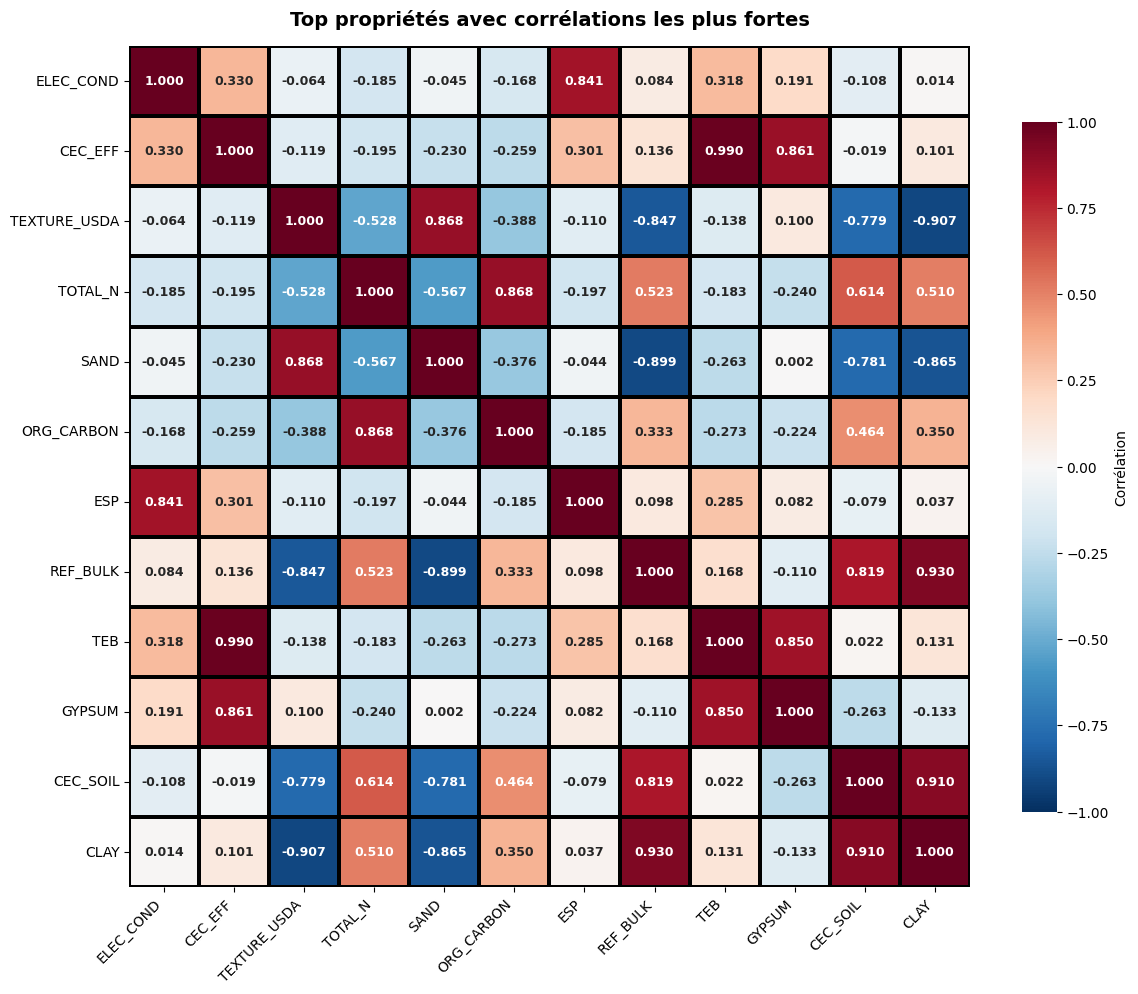


✓ Analyse terminée!


In [10]:
# Nouvelle cellule: Heatmap de corrélation CORRECTE (sans échantillonnage destructif)

import matplotlib.pyplot as plt
import seaborn as sns

print("Construction de la matrice de corrélation spatiale...")

# Créer un DataFrame directement depuis df_joined (qui contient déjà toutes les props par SMU)
# Cela préserve les relations naturelles entre les propriétés du sol

# Sélectionner uniquement les colonnes numériques pour la corrélation
df_for_corr = df_joined[numeric_props].copy()

# Supprimer les lignes avec des valeurs manquantes
df_for_corr_clean = df_for_corr.dropna()

print(f"Nombre de SMU pour l'analyse: {len(df_for_corr_clean):,}")
print(f"Propriétés analysées: {len(numeric_props)}")

# Calculer la matrice de corrélation
correlation_matrix = df_for_corr_clean.corr(method='pearson')

# Afficher un aperçu
print("\nAperçu de la matrice de corrélation:")
print(correlation_matrix.head())

# Sauvegarder
corr_path = os.path.join(data_dir, "correlation_matrix_soil_properties.csv")
correlation_matrix.to_csv(corr_path)
print(f"\n✓ Matrice sauvegardée: {corr_path}")

# ============= HEATMAP PRINCIPALE =============
fig, ax = plt.subplots(figsize=(16, 14))

# Masque pour le triangle supérieur
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Créer la heatmap
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    fmt=".3f",
    cmap="RdBu_r",  # Rouge = corrélation positive, Bleu = négative
    center=0,
    square=True,
    linewidths=1,
    linecolor='white',
    cbar_kws={
        "shrink": 0.8, 
        "label": "Coefficient de corrélation de Pearson",
        "orientation": "vertical"
    },
    vmin=-1, 
    vmax=1,
    annot_kws={"fontsize": 8}
)

plt.title("Matrice de corrélation des propriétés du sol\nAlgérie + Tunisie (HWSD v2)", 
          fontsize=18, pad=25, weight='bold')
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# ============= ANALYSE DES CORRÉLATIONS =============
print("\n" + "="*70)
print("ANALYSE DES CORRÉLATIONS")
print("="*70)

# Extraire toutes les paires de corrélation (sans diagonale)
correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        prop1 = correlation_matrix.columns[i]
        prop2 = correlation_matrix.columns[j]
        corr_val = correlation_matrix.iloc[i, j]
        correlations.append({
            'Propriété 1': prop1,
            'Propriété 2': prop2,
            'Corrélation': corr_val,
            'Abs': abs(corr_val)
        })

df_correlations = pd.DataFrame(correlations).sort_values('Abs', ascending=False)

# Très fortes (|r| > 0.9)
strong = df_correlations[df_correlations['Abs'] > 0.9]
if len(strong) > 0:
    print(f"\n🔴 CORRÉLATIONS TRÈS FORTES (|r| > 0.9): {len(strong)}")
    for _, row in strong.iterrows():
        print(f"  • {row['Propriété 1']} ↔ {row['Propriété 2']}: r = {row['Corrélation']:.3f}")

# Fortes (0.7 < |r| ≤ 0.9)
moderate_strong = df_correlations[(df_correlations['Abs'] > 0.7) & (df_correlations['Abs'] <= 0.9)]
if len(moderate_strong) > 0:
    print(f"\n🟠 CORRÉLATIONS FORTES (0.7 < |r| ≤ 0.9): {len(moderate_strong)}")
    for _, row in moderate_strong.head(10).iterrows():
        print(f"  • {row['Propriété 1']} ↔ {row['Propriété 2']}: r = {row['Corrélation']:.3f}")

# Modérées (0.5 < |r| ≤ 0.7)
moderate = df_correlations[(df_correlations['Abs'] > 0.5) & (df_correlations['Abs'] <= 0.7)]
if len(moderate) > 0:
    print(f"\n🟡 CORRÉLATIONS MODÉRÉES (0.5 < |r| ≤ 0.7): {len(moderate)}")
    print(f"  (Top 5 seulement)")
    for _, row in moderate.head(5).iterrows():
        print(f"  • {row['Propriété 1']} ↔ {row['Propriété 2']}: r = {row['Corrélation']:.3f}")

# Faibles (|r| ≤ 0.5)
weak = df_correlations[df_correlations['Abs'] <= 0.5]
print(f"\n⚪ CORRÉLATIONS FAIBLES (|r| ≤ 0.5): {len(weak)}")

print("\n" + "="*70)
print("STATISTIQUES GLOBALES")
print("="*70)
all_corr = df_correlations['Corrélation'].values
print(f"Nombre total de paires: {len(all_corr)}")
print(f"Corrélation moyenne: {np.mean(all_corr):.3f}")
print(f"Corrélation médiane: {np.median(all_corr):.3f}")
print(f"Écart-type: {np.std(all_corr):.3f}")
print(f"Min: {np.min(all_corr):.3f}")
print(f"Max: {np.max(all_corr):.3f}")

# ============= HEATMAP COMPACTE (Top corrélations) =============
if len(df_correlations) > 0:
    # Sélectionner top 15 corrélations les plus fortes (en valeur absolue)
    top_pairs = df_correlations.head(15)
    
    # Extraire les propriétés impliquées
    top_props = list(set(top_pairs['Propriété 1'].tolist() + top_pairs['Propriété 2'].tolist()))
    
    # Sous-matrice
    sub_corr = correlation_matrix.loc[top_props, top_props]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(
        sub_corr,
        annot=True,
        fmt=".3f",
        cmap="RdBu_r",
        center=0,
        square=True,
        linewidths=1.5,
        linecolor='black',
        cbar_kws={"shrink": 0.8, "label": "Corrélation"},
        vmin=-1,
        vmax=1,
        annot_kws={"fontsize": 9, "weight": "bold"}
    )
    plt.title("Top propriétés avec corrélations les plus fortes", 
              fontsize=14, pad=15, weight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

print("\n✓ Analyse terminée!")

In [11]:
import pandas as pd
import pyodbc

# --- CONFIGURATION ---
FICHIER_MDB = r'C:\Users\hp\Desktop\TPs\DataMining\DATA\Soil\HWSD2.mdb'
NOM_DE_LA_TABLE = 'HWSD_DATA'  # Conserver ce nom par défaut pour l'instant
# --------------------

try:
    # 1. Définir la chaîne de connexion avec le pilote exact listé
    DRIVE = "Microsoft Access Driver (*.mdb, *.accdb)"
    
    # 🛑 Le nom doit être entre accolades
    CONN_STR = f'DRIVER={{{DRIVE}}};DBQ={FICHIER_MDB};'

    # 2. Établir la connexion
    print(f"Tentative de connexion à la base de données MDB en utilisant le pilote: {DRIVE}")
    conn = pyodbc.connect(CONN_STR)

    # 3. Définir la requête SQL pour extraire la table
    SQL_QUERY = f"SELECT * FROM [{NOM_DE_LA_TABLE}]"

    # 4. Lire la table dans un DataFrame pandas
    df_soil = pd.read_sql(SQL_QUERY, conn)

    # 5. Fermer la connexion
    conn.close()

    print(f"\n✅ Succès ! La table '{NOM_DE_LA_TABLE}' a été lue.")
    print(f"Nombre total de lignes extraites : {len(df_soil)}")
    print("\nPremières lignes du DataFrame :")
    print(df_soil.head().to_markdown())

except pyodbc.Error as ex:
    print(f"\n❌ ERREUR PYODBC : {ex}")
    print("\nSuggestion : Si l'erreur persiste, vous avez probablement un problème d'architecture (Python 64-bit vs Pilote 32-bit).")
    print("Veuillez vous assurer que les deux sont de la même architecture.")
except Exception as e:
    print(f"\n❌ Une erreur inattendue est survenue : {e}")

Tentative de connexion à la base de données MDB en utilisant le pilote: Microsoft Access Driver (*.mdb, *.accdb)

❌ Une erreur inattendue est survenue : Execution failed on sql 'SELECT * FROM [HWSD_DATA]': ('42S02', "[42S02] [Microsoft][ODBC Microsoft Access Driver] The Microsoft Access database engine cannot find the input table or query 'HWSD_DATA'. Make sure it exists and that its name is spelled correctly. (-1305) (SQLExecDirectW)")


C:\Users\hp\AppData\Local\Temp\ipykernel_3820\3066637128.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_soil = pd.read_sql(SQL_QUERY, conn)


C:\Users\hp\AppData\Local\Temp\ipykernel_3820\2186623675.py:51: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_smu = pd.read_sql("SELECT * FROM HWSD2_SMU;", conn)
C:\Users\hp\AppData\Local\Temp\ipykernel_3820\2186623675.py:52: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_layer = pd.read_sql("SELECT * FROM HWSD2_LAYERS;", conn)


858 D1-layer soil units matched with raster.


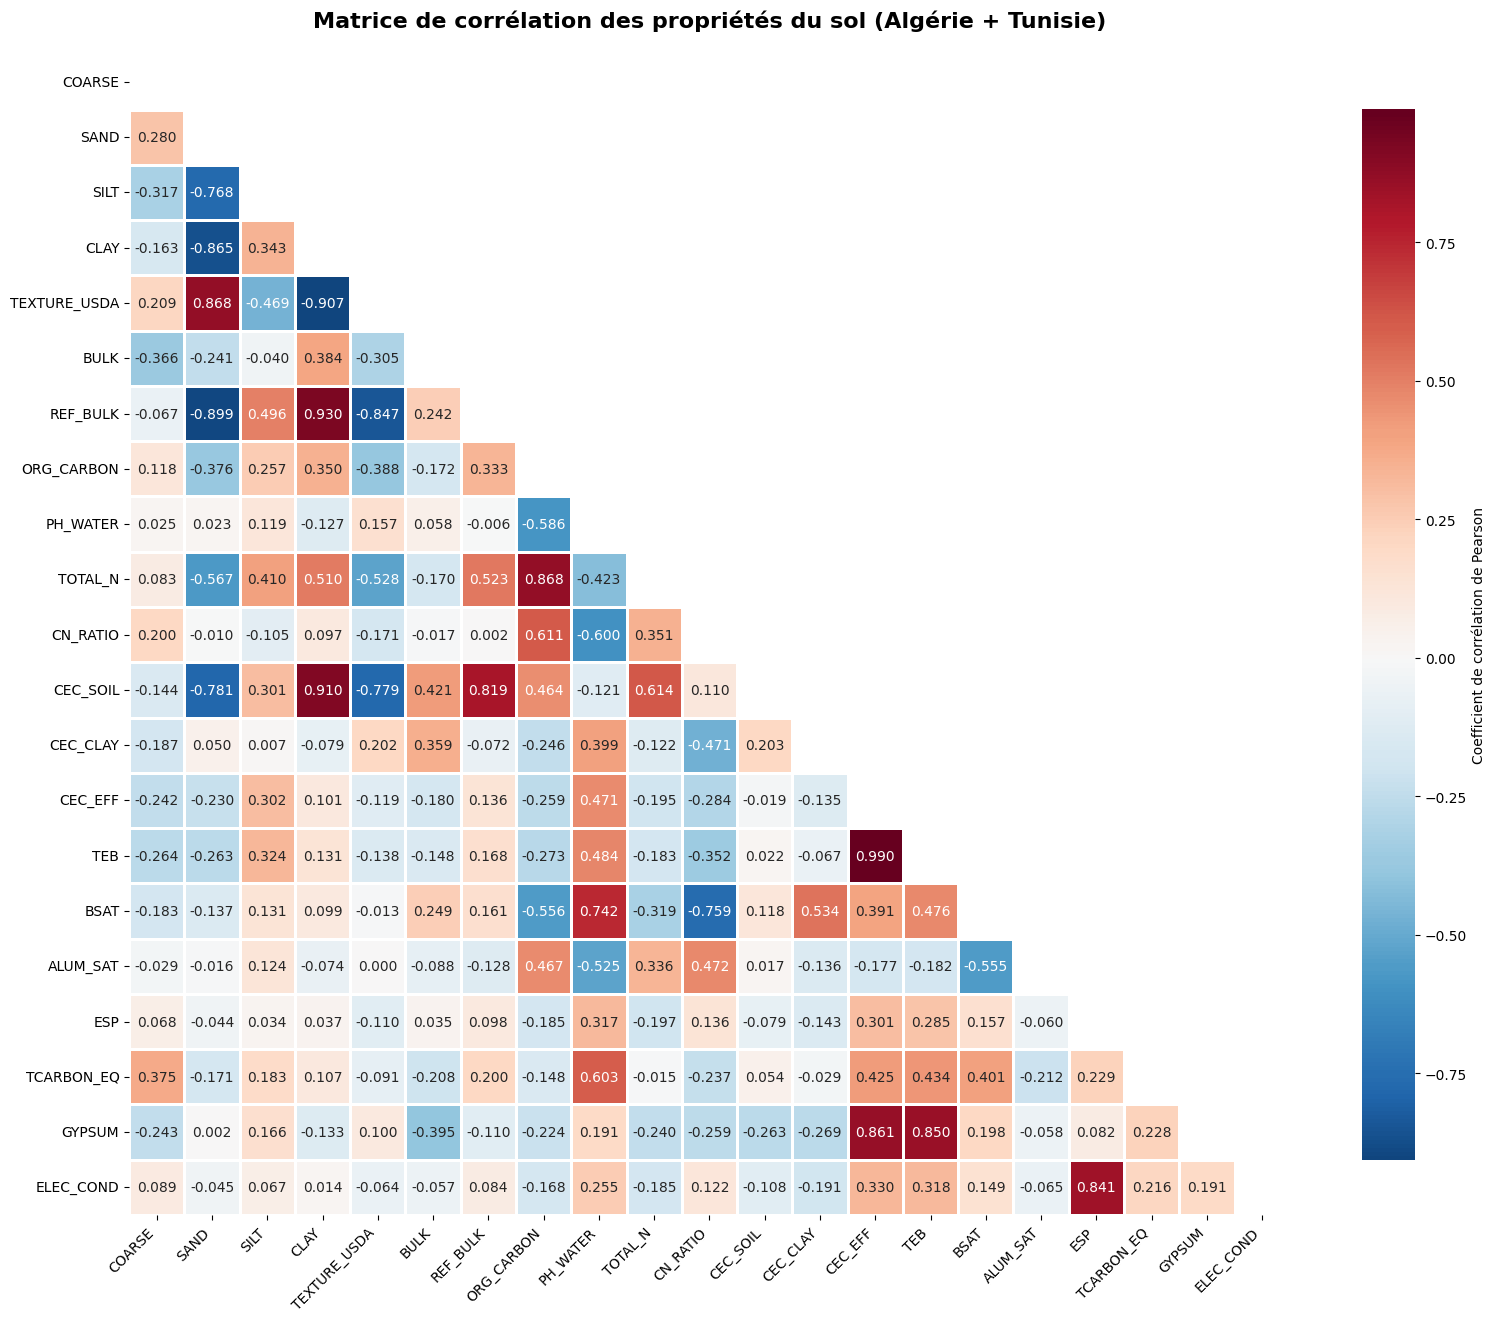

Features trop corrélées à supprimer : ['REF_BULK', 'CEC_SOIL', 'TEB']


Extraction SMU_ID: 100%|██████████| 2490597/2490597 [01:04<00:00, 38627.55it/s]



CSV final des points feu avec propriétés du sol nettoyées sauvegardé : C:\Users\hp\Desktop\TPs\DataMining\DATA\Soil\soil_properties_fire_points_clean.csv


In [12]:
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import pyodbc
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1️⃣ Chemins
# -----------------------------
data_dir = r"C:\Users\hp\Desktop\TPs\DataMining\DATA\Soil"
data_dir2 = r"C:\Users\hp\Desktop\TPs\DataMining\DATA"
bil_path = os.path.join(data_dir, "HWSD2.bil")
mdb_path = os.path.join(data_dir, "HWSD2.mdb")
fire_csv = r"C:\Users\hp\Desktop\TPs\DataMining\csv_final\points+fires.csv"
shp_path = "./countries_data/ne_110m_admin_0_countries.shp"
out_csv = os.path.join(data_dir, "soil_properties_fire_points_clean.csv")
smu_col = "HWSD2_SMU_ID"

# -----------------------------
# 2️⃣ Charger points feu
# -----------------------------
fire_all = pd.read_csv(fire_csv)

# -----------------------------
# 3️⃣ Lire le raster et clip Algérie + Tunisie
# -----------------------------
def clip_algeria_tunisia(shp_path, bil_path):
    countries = gpd.read_file(shp_path)
    north_africa = countries[countries["ADMIN"].isin(["Algeria", "Tunisia"])]
    geoms = [mapping(geom) for geom in north_africa.geometry]
    raster = rasterio.open(bil_path)
    out_image, out_transform = mask(raster, geoms, crop=True)
    raster_data = out_image[0].astype(float)
    raster_data[raster_data == raster.nodata] = np.nan
    return raster_data, raster

raster_data, raster = clip_algeria_tunisia(shp_path, bil_path)

# -----------------------------
# 4️⃣ Lire MDB et filtrer SMU du raster
# -----------------------------
conn_str = rf"DRIVER={{Microsoft Access Driver (*.mdb, *.accdb)}};DBQ={mdb_path};"
conn = pyodbc.connect(conn_str)

df_smu = pd.read_sql("SELECT * FROM HWSD2_SMU;", conn)
df_layer = pd.read_sql("SELECT * FROM HWSD2_LAYERS;", conn)
conn.close()

# Filtrer SMU présents dans le raster
unique_ids = np.unique(raster_data[~np.isnan(raster_data)]).astype(int)
df_smu = df_smu[df_smu[smu_col].isin(unique_ids)]

# Filtrer couche D1
df_layer_d1 = df_layer[df_layer["LAYER"].str.upper() == "D1"].copy()

# Sélection des colonnes existantes dans la couche D1
desired_cols = [
    smu_col, "LAYER", "COARSE", "SAND", "SILT", "CLAY",
    "TEXTURE_USDA", "TEXTURE_SOTER", "BULK", "REF_BULK", "ORG_CARBON",
    "PH_WATER", "TOTAL_N", "CN_RATIO", "CEC_SOIL", "CEC_CLAY", "CEC_EFF",
    "TEB", "BSAT", "ALUM_SAT", "ESP", "TCARBON_EQ", "GYPSUM", "ELEC_COND"
]
selected_features = [col for col in desired_cols if col in df_layer_d1.columns]
df_layer_d1 = df_layer_d1[selected_features]

# Merge complet pour obtenir df_joined
df_joined = pd.merge(df_smu[[smu_col]], df_layer_d1, on=smu_col, how="inner")
print(f"{len(df_joined)} D1-layer soil units matched with raster.")

# -----------------------------
# 5️⃣ Matrice de corrélation complète
# -----------------------------
numeric_props = [col for col in df_joined.select_dtypes(include=[np.number]).columns if col != smu_col]

df_for_corr_clean = df_joined[numeric_props].dropna()
correlation_matrix = df_for_corr_clean.corr(method='pearson')

# Affichage heatmap complète
plt.figure(figsize=(16,14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    fmt=".3f",
    cmap="RdBu_r",
    center=0,
    square=True,
    linewidths=1,
    linecolor='white',
    cbar_kws={"shrink":0.8, "label":"Coefficient de corrélation de Pearson"}
)
plt.title("Matrice de corrélation des propriétés du sol (Algérie + Tunisie)", fontsize=16, pad=20, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# -----------------------------
# 6️⃣ Supprimer features trop corrélées
# -----------------------------
threshold = 0.9
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
print("Features trop corrélées à supprimer :", to_drop)
df_soil_clean = df_joined.drop(columns=to_drop)

# -----------------------------
# 7️⃣ Extraire SMU pour chaque point feu
# -----------------------------
coords = [(lon, lat) for lon, lat in zip(fire_all["longitude"], fire_all["latitude"])]
smu_values = []
for val in tqdm(raster.sample(coords), total=len(coords), desc="Extraction SMU_ID"):
    smu_values.append(val[0])
fire_all["SMU_ID"] = smu_values

# -----------------------------
# 8️⃣ Associer les propriétés du sol aux points feu
# -----------------------------
df_fire_soil = pd.merge(fire_all, df_soil_clean, left_on="SMU_ID", right_on=smu_col, how="left")

# -----------------------------
# 9️⃣ Sauvegarder CSV final
# -----------------------------
df_fire_soil.to_csv(out_csv, index=False)
print(f"\nCSV final des points feu avec propriétés du sol nettoyées sauvegardé : {out_csv}")

In [13]:
import pandas as pd

# 🛑 Remplacez le chemin par le chemin exact où se trouve votre fichier si nécessaire
CHEMIN_FICHIER = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\DATA\\Soil\\soil_properties_fire_points_clean.csv'
COL_LAT = 'latitude'
COL_LON = 'longitude'

try:
    # 1. Lire le fichier CSV
    df = pd.read_csv(CHEMIN_FICHIER)
    
    # 2. Filtrer le DataFrame pour ne garder que les lignes où 'classe' est égale à 1
    df_feux = df[df['classe'] == 1]
    
  # 3. Compter le nombre de combinaisons uniques (Lat/Lon)
    # On utilise drop_duplicates() sur les colonnes de coordonnées et on compte le résultat
    nombre_coordonnees_uniques = df_feux.drop_duplicates(subset=[COL_LAT, COL_LON]).shape[0]
    
    print(f"--- Résultat de la Vérification ---")
    print(f"Total des lignes originales (classe=1) : {len(df_feux)}")
    print(f"✅ Nombre de coordonnées uniques (où classe=1) : {nombre_coordonnees_uniques}")
    
    if len(df_feux) != nombre_coordonnees_uniques:
        print(f"\n💡 Note : {len(df_feux) - nombre_coordonnees_uniques} feux se sont produits au même emplacement Lat/Lon.")
    
except FileNotFoundError:
    print(f"❌ Erreur : Le fichier n'a pas été trouvé à l'adresse : {CHEMIN_FICHIER}")
except KeyError as e:
    print(f"❌ Erreur : Une colonne clé est manquante ({e}). Vérifiez que le nom des colonnes 'classe', 'latitude' et 'longitude' est correct.")
except Exception as e:
    print(f"❌ Une erreur est survenue lors du traitement : {e}")

--- Résultat de la Vérification ---
Total des lignes originales (classe=1) : 17711
✅ Nombre de coordonnées uniques (où classe=1) : 8841

💡 Note : 8870 feux se sont produits au même emplacement Lat/Lon.


In [14]:
import pandas as pd

df=pd.read_csv(r"C:\Users\hp\Desktop\TPs\DataMining\DATA\Soil\soil_properties_fire_points_clean.csv")
print(df.head())

   latitude  longitude  classe  SMU_ID  HWSD2_SMU_ID LAYER  COARSE  SAND  \
0    18.969      3.325       0    1796        1796.0    D1    12.0  57.0   
1    18.969      3.334       0    1796        1796.0    D1    12.0  57.0   
2    18.969      3.344       0    1796        1796.0    D1    12.0  57.0   
3    18.969      3.353       0    1796        1796.0    D1    12.0  57.0   
4    18.969      3.363       0    1796        1796.0    D1    12.0  57.0   

   SILT  CLAY  ...  TOTAL_N CN_RATIO  CEC_CLAY  CEC_EFF   BSAT  ALUM_SAT  ESP  \
0  27.0  16.0  ...     0.73      9.0      74.0     30.0  100.0       0.0  3.0   
1  27.0  16.0  ...     0.73      9.0      74.0     30.0  100.0       0.0  3.0   
2  27.0  16.0  ...     0.73      9.0      74.0     30.0  100.0       0.0  3.0   
3  27.0  16.0  ...     0.73      9.0      74.0     30.0  100.0       0.0  3.0   
4  27.0  16.0  ...     0.73      9.0      74.0     30.0  100.0       0.0  3.0   

   TCARBON_EQ  GYPSUM  ELEC_COND  
0         8.0     4.0

In [15]:
import pandas as pd
import numpy as np

# --- CONFIGURATION ---
CHEMIN_FICHIER_ENTREE = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\DATA\\Soil\\soil_properties_fire_points_clean.csv'
CHEMIN_FICHIER_SORTIE = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\DATA\\Soil\\soil_data_texture_cleaned.csv' 
# --------------------

# La clé de la duplication
COLONNES_GEO = ['latitude', 'longitude', 'classe'] 
# La clé de la dominance pour le choix
COLONNES_TEXTURE = ['SAND', 'SILT', 'CLAY']

try:
    # 1. Chargement des données
    df = pd.read_csv(CHEMIN_FICHIER_ENTREE)
    lignes_originales = len(df)
    
    print(f"Fichier chargé. Total des lignes (avec duplications de sol) : {lignes_originales}")
    
    # 2. Identifier le sol dominant par texture
    df['MAX_TEXTURE'] = df[COLONNES_TEXTURE].max(axis=1)

    # 3. Trier les duplications et conserver la ligne dominante
    
    # 3.1. Trier : Regrouper par coordonnées/classe, puis classer par MAX_TEXTURE (Descendant)
    df_sorted = df.sort_values(
        by=COLONNES_GEO + ['MAX_TEXTURE'],
        ascending=[True, True, True, False]
    )

    # 3.2. Supprimer les doublons, en conservant uniquement le sol dominant (la première ligne après le tri)
    df_cleaned = df_sorted.drop_duplicates(subset=COLONNES_GEO, keep='first').copy()
    
    # 4. Finalisation
    df_cleaned.drop(columns=['MAX_TEXTURE'], inplace=True)
    
    # 5. Sauvegarde
    df_cleaned.to_csv(CHEMIN_FICHIER_SORTIE, index=False)
    
    lignes_supprimees = lignes_originales - len(df_cleaned)
    print(f"\n✅ Nettoyage terminé. Total des lignes conservées (uniques par point) : {len(df_cleaned)}")
    print(f"Nombre de lignes d'attributs de sol secondaires supprimées : {lignes_supprimees}")
    print(f"Le fichier nettoyé est sauvegardé à : {CHEMIN_FICHIER_SORTIE}")
    
    print("\n--- Prochaine Étape ---")
    print("Utilisez le nouveau fichier 'soil_data_texture_cleaned.csv' pour la fusion finale avec les données de climat et d'élévation.")


except FileNotFoundError:
    print(f"❌ Erreur : Le fichier d'entrée n'a pas été trouvé.")
except KeyError as e:
    print(f"❌ Erreur : Une colonne est manquante ({e}). Vérifiez les noms des colonnes.")
except Exception as e:
    print(f"❌ Une erreur inattendue est survenue : {e}")

Fichier chargé. Total des lignes (avec duplications de sol) : 5376197

✅ Nettoyage terminé. Total des lignes conservées (uniques par point) : 2490597
Nombre de lignes d'attributs de sol secondaires supprimées : 2885600
Le fichier nettoyé est sauvegardé à : C:\Users\hp\Desktop\TPs\DataMining\DATA\Soil\soil_data_texture_cleaned.csv

--- Prochaine Étape ---
Utilisez le nouveau fichier 'soil_data_texture_cleaned.csv' pour la fusion finale avec les données de climat et d'élévation.


In [16]:
import pandas as pd

# --- CONFIGURATION ---
CHEMIN_FICHIER = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\DATA\\Soil\\soil_data_texture_cleaned.csv' # 🛑 Remplacez par le chemin du fichier
COLONNES_CLE = ['latitude', 'longitude']
# --------------------

try:
    # 1. Charger le DataFrame
    df = pd.read_csv(CHEMIN_FICHIER)
    
    # 2. Identifier les doublons
    # La méthode duplicated(subset=..., keep=False) marque toutes les occurrences (originale ET doubles) des lignes dupliquées.
    masque_doublons = df.duplicated(subset=COLONNES_CLE, keep=False)
    
    # 3. Filtrer pour obtenir uniquement les lignes dupliquées
    df_doublons = df[masque_doublons]
    
    # 4. Compter et afficher le résultat
    nombre_doublons = len(df_doublons)
    nombre_de_paires_uniques_dupliquees = len(df_doublons.drop_duplicates(subset=COLONNES_CLE))
    
    print(f"--- Résultat de la Vérification ---")
    print(f"Total des lignes dans le fichier : {len(df)}")
    
    if nombre_doublons > 0:
        # On divise par 2 si chaque paire n'est dupliquée qu'une seule fois
        print(f"⚠️ **ATTENTION :** {nombre_doublons} lignes sont impliquées dans des duplications.")
        print(f"Ce qui représente {nombre_de_paires_uniques_dupliquees} paires de coordonnées géographiques uniques dupliquées.")
        
        # Afficher les 10 premiers doublons pour inspection
        print("\nDix premières occurrences dupliquées (pour inspection) :")
        print(df_doublons.head(10).sort_values(by=COLONNES_CLE).to_markdown())
        
    else:
        print("✅ **SUCCÈS :** Aucune duplication trouvée sur les colonnes 'latitude' et 'longitude'.")

except FileNotFoundError:
    print(f"❌ Erreur : Le fichier n'a pas été trouvé à l'adresse : {CHEMIN_FICHIER}")
except KeyError as e:
    print(f"❌ Erreur : Une colonne clé est manquante ({e}). Vérifiez que les noms des colonnes sont bien 'latitude' et 'longitude'.")

--- Résultat de la Vérification ---
Total des lignes dans le fichier : 2490597
✅ **SUCCÈS :** Aucune duplication trouvée sur les colonnes 'latitude' et 'longitude'.


In [17]:
import pandas as pd

# 🛑 Remplacez par le chemin du fichier que vous souhaitez inspecter
CHEMIN_FICHIER = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\DATA\\Soil\\soil_data_texture_cleaned.csv'

try:
    # 1. Charger le DataFrame
    df = pd.read_csv(CHEMIN_FICHIER)
    total_lignes = len(df)
    
    print(f"--- Analyse des Valeurs Manquantes dans {CHEMIN_FICHIER.split('\\')[-1]} ---")
    
    # 2. Identifier les lignes avec au moins une valeur manquante
    # df.isnull().any(axis=1) retourne True si n'importe quelle colonne de la ligne est NaN
    masque_lignes_manquantes = df.isnull().any(axis=1)
    
    # 3. Compter les lignes
    df_lignes_manquantes = df[masque_lignes_manquantes]
    nombre_lignes_manquantes = len(df_lignes_manquantes)
    
    # 4. Calculer le pourcentage
    pourcentage_manquant = (nombre_lignes_manquantes / total_lignes) * 100
    
    print(f"\nTotal des lignes dans le DataFrame : {total_lignes}")
    print(f"Nombre de lignes contenant au moins un NaN : {nombre_lignes_manquantes}")
    print(f"Pourcentage du jeu de données affecté : {pourcentage_manquant:.2f}%")
    
    if nombre_lignes_manquantes > 0:
        print("\n⚠️ **Diagnostic (pour voir où commence le problème) :**")
        # Afficher les 5 premières lignes avec des NaN pour inspection
        print(df_lignes_manquantes.head().to_markdown())
    else:
        print("\n✅ **SUCCÈS :** Aucune ligne complète ne contient de valeur manquante.")
        
except FileNotFoundError:
    print(f"\n❌ Erreur : Le fichier n'a pas été trouvé à l'adresse : {CHEMIN_FICHIER}")
except Exception as e:
    print(f"\n❌ Une erreur inattendue est survenue : {e}")

--- Analyse des Valeurs Manquantes dans soil_data_texture_cleaned.csv ---

Total des lignes dans le DataFrame : 2490597
Nombre de lignes contenant au moins un NaN : 585216
Pourcentage du jeu de données affecté : 23.50%

⚠️ **Diagnostic (pour voir où commence le problème) :**
|     |   latitude |   longitude |   classe |   SMU_ID |   HWSD2_SMU_ID | LAYER   |   COARSE |   SAND |   SILT |   CLAY |   TEXTURE_USDA | TEXTURE_SOTER   |   BULK |   ORG_CARBON |   PH_WATER |   TOTAL_N |   CN_RATIO |   CEC_CLAY |   CEC_EFF |   BSAT |   ALUM_SAT |   ESP |   TCARBON_EQ |   GYPSUM |   ELEC_COND |
|----:|-----------:|------------:|---------:|---------:|---------------:|:--------|---------:|-------:|-------:|-------:|---------------:|:----------------|-------:|-------------:|-----------:|----------:|-----------:|-----------:|----------:|-------:|-----------:|------:|-------------:|---------:|------------:|
| 121 |     19.014 |       3.534 |        0 |       36 |             36 | D1      |       -4 |  

In [18]:
df=pd.read_csv(r"C:\Users\hp\Desktop\TPs\DataMining\DATA\Soil\soil_data_texture_cleaned.csv")
print(df.head())

   latitude  longitude  classe  SMU_ID  HWSD2_SMU_ID LAYER  COARSE  SAND  \
0    18.969      3.325       0    1796        1796.0    D1    12.0  57.0   
1    18.969      3.334       0    1796        1796.0    D1    12.0  57.0   
2    18.969      3.344       0    1796        1796.0    D1    12.0  57.0   
3    18.969      3.353       0    1796        1796.0    D1    12.0  57.0   
4    18.969      3.363       0    1796        1796.0    D1    12.0  57.0   

   SILT  CLAY  ...  TOTAL_N CN_RATIO  CEC_CLAY  CEC_EFF   BSAT  ALUM_SAT  ESP  \
0  27.0  16.0  ...     0.73      9.0      74.0     30.0  100.0       0.0  3.0   
1  27.0  16.0  ...     0.73      9.0      74.0     30.0  100.0       0.0  3.0   
2  27.0  16.0  ...     0.73      9.0      74.0     30.0  100.0       0.0  3.0   
3  27.0  16.0  ...     0.73      9.0      74.0     30.0  100.0       0.0  3.0   
4  27.0  16.0  ...     0.73      9.0      74.0     30.0  100.0       0.0  3.0   

   TCARBON_EQ  GYPSUM  ELEC_COND  
0         8.0     4.0

In [19]:
import pandas as pd
import numpy as np

# --- CONFIGURATION ---
# 🛑 Assurez-vous que le fichier d'entrée est le fichier FINAL nettoyé des doublons de sol.
CHEMIN_FICHIER_ENTREE = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\DATA\\Soil\\soil_data_texture_cleaned.csv'
CHEMIN_FICHIER_SORTIE = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\DATA\\Soil\\dataset_final_impute_v2.csv'

# Liste mise à jour incluant le nouveau code -9
VALEURS_NAN_CODEES = [-4, -9999, -9, -3, -5, -1] 
# --------------------

try:
    # 1. Chargement et nettoyage des codes NoData
    df = pd.read_csv(CHEMIN_FICHIER_ENTREE)
    total_lignes = len(df)
    
    print(f"--- Début du Nettoyage des codes {VALEURS_NAN_CODEES} en NaN ---")
    
    # Remplacer les codes NoData par le marqueur standard np.nan dans toutes les colonnes numériques
    colonnes_numeriques = df.select_dtypes(include=[np.number]).columns
    df[colonnes_numeriques] = df[colonnes_numeriques].replace(VALEURS_NAN_CODEES, np.nan)
    
    print(f"\nNettoyage des codes terminé. Début de l'Imputation Sélective.")
    
    # 2. Identifier toutes les colonnes à imputer
    colonnes_a_imputer = df.columns[df.isnull().any()].tolist()
    
    if not colonnes_a_imputer:
        print("\n✅ Aucune valeur manquante restante à imputer.")
    else:
        for col in colonnes_a_imputer:
            
            # --- Cas 1 : Variables Numériques (Sol, Climat, Altitude) ---
            if pd.api.types.is_numeric_dtype(df[col]):
                # Imputation par la Médiane pour la robustesse (méthode sécurisée)
                mediane = df[col].median()
                df[col].fillna(mediane, inplace=True)
                print(f"   -> Imputation Numérique (Médiane) : '{col}' (valeur: {mediane:.3f})")
            
            # --- Cas 2 : Variables Catégorielles (TEXTURE_USDA, etc.) ---
            elif pd.api.types.is_object_dtype(df[col]):
                # Imputation par la catégorie "Missing" pour éviter le biais (méthode sécurisée)
                df[col].fillna("Missing", inplace=True)
                print(f"   -> Imputation Catégorielle (Nouvelle Catégorie) : '{col}' (valeur: Missing)")
            
            # --- Cas 3 : Autres types (gestion par le mode par sécurité) ---
            else:
                mode = df[col].mode()[0]
                df[col].fillna(mode, inplace=True)
                print(f"   -> Imputation Autres (Mode) : '{col}' (valeur: {mode})")


        # 3. Vérification finale
        nombre_lignes_manquantes_final = df.isnull().any(axis=1).sum()
        print(f"\n✅ Imputation terminée. Nombre final de lignes avec NaN : {nombre_lignes_manquantes_final}")
    
    # 4. Sauvegarde
    df.to_csv(CHEMIN_FICHIER_SORTIE, index=False)
    print(f"\nLe fichier FINAL, nettoyé et imputé, est sauvegardé à : {CHEMIN_FICHIER_SORTIE}")
    
except FileNotFoundError:
    print(f"\n❌ Erreur : Le fichier d'entrée n'a pas été trouvé à l'adresse : {CHEMIN_FICHIER_ENTREE}")
except Exception as e:
    print(f"\n❌ Une erreur inattendue est survenue : {e}")

--- Début du Nettoyage des codes [-4, -9999, -9, -3, -5, -1] en NaN ---

Nettoyage des codes terminé. Début de l'Imputation Sélective.
   -> Imputation Numérique (Médiane) : 'longitude' (valeur: 3.487)


C:\Users\hp\AppData\Local\Temp\ipykernel_3820\1080283682.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mediane, inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_3820\1080283682.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 

   -> Imputation Numérique (Médiane) : 'HWSD2_SMU_ID' (valeur: 1644.000)
   -> Imputation Catégorielle (Nouvelle Catégorie) : 'LAYER' (valeur: Missing)
   -> Imputation Numérique (Médiane) : 'COARSE' (valeur: 18.000)
   -> Imputation Numérique (Médiane) : 'SAND' (valeur: 66.000)
   -> Imputation Numérique (Médiane) : 'SILT' (valeur: 22.000)
   -> Imputation Numérique (Médiane) : 'CLAY' (valeur: 14.000)


C:\Users\hp\AppData\Local\Temp\ipykernel_3820\1080283682.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mediane, inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_3820\1080283682.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 

   -> Imputation Numérique (Médiane) : 'TEXTURE_USDA' (valeur: 11.000)
   -> Imputation Catégorielle (Nouvelle Catégorie) : 'TEXTURE_SOTER' (valeur: Missing)
   -> Imputation Numérique (Médiane) : 'BULK' (valeur: 1.370)
   -> Imputation Numérique (Médiane) : 'ORG_CARBON' (valeur: 0.711)
   -> Imputation Numérique (Médiane) : 'PH_WATER' (valeur: 7.400)
   -> Imputation Numérique (Médiane) : 'TOTAL_N' (valeur: 0.580)


C:\Users\hp\AppData\Local\Temp\ipykernel_3820\1080283682.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mediane, inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_3820\1080283682.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 

   -> Imputation Numérique (Médiane) : 'CN_RATIO' (valeur: 12.000)
   -> Imputation Numérique (Médiane) : 'CEC_CLAY' (valeur: 35.000)
   -> Imputation Numérique (Médiane) : 'CEC_EFF' (valeur: 25.000)
   -> Imputation Numérique (Médiane) : 'BSAT' (valeur: 64.000)
   -> Imputation Numérique (Médiane) : 'ALUM_SAT' (valeur: 0.000)
   -> Imputation Numérique (Médiane) : 'ESP' (valeur: 3.000)
   -> Imputation Numérique (Médiane) : 'TCARBON_EQ' (valeur: 6.300)


C:\Users\hp\AppData\Local\Temp\ipykernel_3820\1080283682.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mediane, inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_3820\1080283682.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 

   -> Imputation Numérique (Médiane) : 'GYPSUM' (valeur: 0.300)
   -> Imputation Numérique (Médiane) : 'ELEC_COND' (valeur: 1.000)

✅ Imputation terminée. Nombre final de lignes avec NaN : 0

Le fichier FINAL, nettoyé et imputé, est sauvegardé à : C:\Users\hp\Desktop\TPs\DataMining\DATA\Soil\dataset_final_impute_v2.csv
